In [1]:
show_plots = True
car_free = False
run_both = True

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.io.display import all_pt_paths, path, pt_path
%matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [3]:
# Load the network model from the last exercise
model_path = '../model/'
input_path = '../input/'
output_path = '../outputs/'

In [4]:

sm = stepmodel.read_json(model_path + 'network')

In [5]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:",broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters']
Successfully fixed.


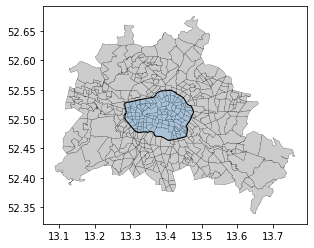

In [6]:
umweltzone = gpd.read_file(input_path + "zones/Umweltzone_-_Berlin")
umweltzone = umweltzone.to_crs(epsg=sm.epsg)
umweltzone_geom = umweltzone['geometry'].iloc[0]
if show_plots: umweltzone.plot(color="#2299ff33", edgecolor="black", linewidth=1, ax=sm.zones.plot(color="#cccccc", edgecolor="black", linewidth=0.2))

## Preparation of OD-times

The pathfinders need a column "time" in the links or road_links tables to find the shortest paths. The PT pathfinder also applies a generalized boarding time (can be interpreted as a penalty for interchanging between transport carriers) and a waiting time, which is computed from the headway of PT carriers (waiting time equals half the headway (in seconds) assuming a randomly and evenly distributed arrival pattern of passengers on every PT stop).

In [7]:
sm.road_links.sample(1)

,a,b,length,validation_load,validation_share,geometry,highway,maxspeed,validation_threshold
index,,,,,,,,,
1261,25954550,29192133,50.916,0.0,0.0,"LINESTRING (13.39808 52.52726, 13.39785 52.52769)",residential,10,False


In [8]:
sm.links.sample(1)

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,route_color,road_a,road_b,road_length,geometry,road_node_list,road_link_list
index,,,,,,,,,,,,,,,,,,,
link_11278,17459_900_2,n_node_de:11000:900120511::3,n_node_de:11000:900100040::10,22,120.0,600,17459_900_2,17459_900,482,0,796,tram,None,218739803,29221603,NaN,"LINESTRING (13.42547 52.52334, 13.42024 52.52522)",[],[]


In [9]:
# We don't see any length column in our links,
# but it is nice for calculating speeds and for later steps.
# We can cast the PT network onto the road network (as in A40)
# Start with the bus links
bus = sm.copy() # copy the whole model
bus.links = bus.links.loc[bus.links['route_type'].isin(['bus'])] # Filter
# Apply quetzal's casting function
bus.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

10231_700_2: 100%|██████████| 441/441 [01:39<00:00,  4.43it/s]


In [10]:
bus.links.sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,route_color,road_a,road_b,road_node_list,road_link_list,road_length,geometry
index,,,,,,,,,,,,,,,,,,,
link_5468,17347_700_0,n_node_de:11000:900171002::4,n_node_de:11000:900161516::1,2,90.0,1200,17347_700_0,17347_700,482,1,796,bus,None,12614668,654192032,"[12614668, 486432642, 9982763016, 521610310, 6...","[119559, 135377, 119772, 120953]",737.277,"LINESTRING (13.51919 52.51346, 13.52394 52.513..."


In [11]:
# Now take the road_length of casted model as the length of our genuine model
sm.links['length'] = np.nan # create a new column with default values
sm.links.loc[sm.links['route_type'].isin(['bus']),
             'length'] = bus.links['road_length']

In [12]:
# For rail links, we can assign the geometric distance
sm.links.loc[sm.links['length'].isna(), 'length'] = \
    sm.links.loc[sm.links['length'].isna(), 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))
# Take the geometric line and from it the start and end points, then calculate the meter distance in between

In [13]:
# You can calculate the average bus operation speed
bus = sm.links.loc[sm.links['route_type'] == 'bus'] # filter
bus_lines = bus.groupby('route_id')[['time', 'length']].sum() # sum up time and length for each route
bus_speed = bus['length'].sum() / bus['time'].sum() # operation speed
print('bus_speed =', bus_speed, 'm / s', bus_speed*3.6, 'km/h')

bus_speed = 5.124441415003501 m / s 18.447989094012605 km/h


In [14]:
sm.road_links.head(3)

,a,b,length,validation_load,validation_share,geometry,highway,maxspeed,validation_threshold
index,,,,,,,,,
1,172539,34694265,237.653,10379.796248,1.0,"LINESTRING (13.33550 52.56521, 13.33859 52.56428)",tertiary,50,True
2,172539,34694336,687.484,13820.164605,1.0,"LINESTRING (13.33550 52.56521, 13.34515 52.56680)",secondary,50,True
3,172539,3977742457,391.153,19240.567732,1.0,"LINESTRING (13.33550 52.56521, 13.33114 52.56289)",secondary,50,True


## add speed information to road link

#### fixing broken 'maxspeed' column as it contains None, strings not convertable to numbers and lists 

In [15]:
y = 0
a = [item for sublist in \
        [item for sublist in \
            [[[x for n, x in a1 if not x in a2[:n]] \
                for a1, a2 in [(enumerate(sm.road_links['maxspeed'].values[y:y+len(sm.road_links)//1000]), sm.road_links['maxspeed'].values[y:y+len(sm.road_links)//1000])]] \
            for y in np.array(range(len(sm.road_links)//1000+1))*1000]\
        for item in sublist]\
    for item in sublist]

In [16]:
allHighwayTypes = []

for val in sm.road_links['highway'].values:
    if type(val)==list:
        for v in val:
            if not v in allHighwayTypes:
                allHighwayTypes.append(v)
    elif not val in allHighwayTypes:
        allHighwayTypes.append(val)

print(allHighwayTypes)


['tertiary', 'secondary', 'residential', 'primary', 'primary_link', 'motorway_link', 'motorway', 'unclassified', 'secondary_link', 'trunk_link', 'living_street', 'trunk', 'tertiary_link', 'razed']


In [17]:
realisticSpeedDict={30: 25, 100: 70}
speedReduction = .7

In [18]:
non_valid_speed_str = [None, 'walk','DE:urban']
maxspeed_clean = np.asarray([np.asarray(x).astype(int).mean() if type(x) == list else int(x) for x in sm.road_links['maxspeed'].values if x not in non_valid_speed_str])

maxSpeedByType = {}
effectiveSpeedByType = {}
for key in allHighwayTypes:
    fltrd = maxspeed_clean[[key in x if type(x)==list else x==key for x, y in zip(sm.road_links['highway'].values, sm.road_links['maxspeed'].values) if y not in non_valid_speed_str]]
    if len(fltrd)>0:
        maxSpeedByType[key] = round(fltrd.astype(int).mean(),2)
        effectiveSpeedByType[key] = maxSpeedByType[key]*speedReduction
    else:     
        maxSpeedByType[key] = 0.1
        effectiveSpeedByType[key] = 0.1
maxSpeedByType

{'tertiary': 45.48,
 'secondary': 47.9,
 'residential': 30.68,
 'primary': 48.54,
 'primary_link': 48.14,
 'motorway_link': 56.78,
 'motorway': 75.58,
 'unclassified': 40.28,
 'secondary_link': 48.88,
 'trunk_link': 48.0,
 'living_street': 25.69,
 'trunk': 51.67,
 'tertiary_link': 47.19,
 'razed': 0.1}

In [19]:
maxspeed_cleaned = np.asarray([np.asarray(mxsp).astype(int).mean()*speedReduction if type(mxsp) == list \
    else np.asarray([effectiveSpeedByType[h] for h in hw]).mean() if type(hw)==list \
    else effectiveSpeedByType[hw] if mxsp in non_valid_speed_str \
    else np.float64(mxsp)*speedReduction \
for hw,mxsp in zip(sm.road_links['highway'].values, sm.road_links['maxspeed'].values)])

sm.road_links['avspeed'] = maxspeed_cleaned

In [20]:
# if show_plots:
#     fig, ax = plt.subplots(nrows=2, figsize = (16,24))
#     sm.road_links.plot(ax=ax.flat[0], cmap="viridis", column=np.array([type(x) for x in sm.road_links['maxspeed']]), linewidth=0.2, legend=True)
#     sm.road_links.plot(ax=ax.flat[1], cmap="Reds", column=maxspeed_cleaned, linewidth=(maxspeed_cleaned/100), legend=True)

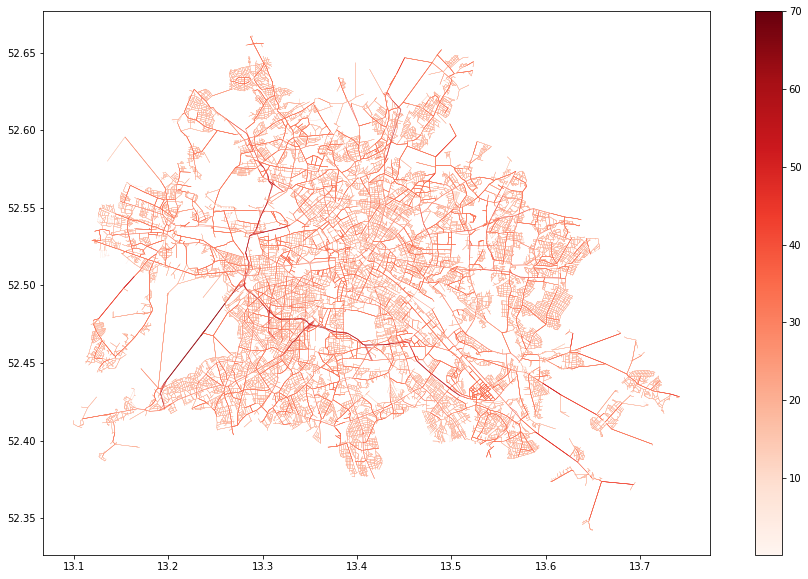

In [21]:
if show_plots:
    fig, ax = plt.subplots(nrows=1, figsize = (16,10))
    sm.road_links.plot(ax=ax, cmap="Reds", column=maxspeed_cleaned, linewidth=(maxspeed_cleaned/100), legend=True)

In [22]:
# Create the time LoS column for cars (it's already there for PT from the GTFS feeds)
# car_speed = bus_speed * 1.25
# sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s
sm.road_links['time'] = sm.road_links['length'] / (sm.road_links['avspeed'] *1000/(60**2))

<AxesSubplot:>

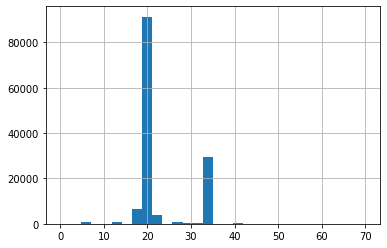

In [23]:
r = sm.road_links['length']/sm.road_links['time']*3.6
r.hist(bins=30)

In [24]:
# If we want to compute walking paths on road links, we need a time for that to
# sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car
sm.road_links['walk_time'] = sm.road_links['length'] / (5/3.6) # walk with 5 km/h per hour
# sm.road_links['bike_time'] = sm.road_links['length'] / (16.5/3.6) #
print('walk_speed', bus_speed * 1.25 / 3 *3.6, 'km/h seems too fast.')

walk_speed 7.686662122505252 km/h seems too fast.


## set umweltzone car free or not

In [25]:
sm_outside = sm.copy()

inside_zone_ids = sm.zones.index.values[sm.centroids.geometry.apply(lambda g: g.within(umweltzone_geom))]
outside_zone_ids = sm.zones.index.values[sm.centroids.geometry.apply(lambda g: not g.within(umweltzone_geom))]

sm_outside.zones = sm_outside.zones[[i in outside_zone_ids for i in sm_outside.zones.index.values]].copy() 
sm_outside.centroids = sm_outside.centroids[[i in outside_zone_ids for i in sm_outside.centroids.index.values]].copy()
sm_outside.road_links = sm.road_links[sm.road_links.apply(lambda row: row['highway'] == 'motorway' or not row['geometry'].intersects(umweltzone_geom), axis=1)].copy()
sm_outside.zone_to_road = sm_outside.zone_to_road[sm_outside.zone_to_road.apply(lambda row: row['a'] in outside_zone_ids or row['b'] in outside_zone_ids, axis=1)].copy()

In [26]:
# set ['highway'] != 'motorway'because stadtautobahn intersects umweltzone eventhough it should be considered completly outside
inside_road_links = sm.road_links[sm.road_links.apply(lambda row: row['highway'] != 'motorway' and row['geometry'].intersects(umweltzone_geom), axis=1)]
inside_outside_connection_links = sm.road_links[sm.road_links.apply(lambda row: row['highway'] != 'motorway' and row['geometry'].crosses(umweltzone_geom), axis=1)]

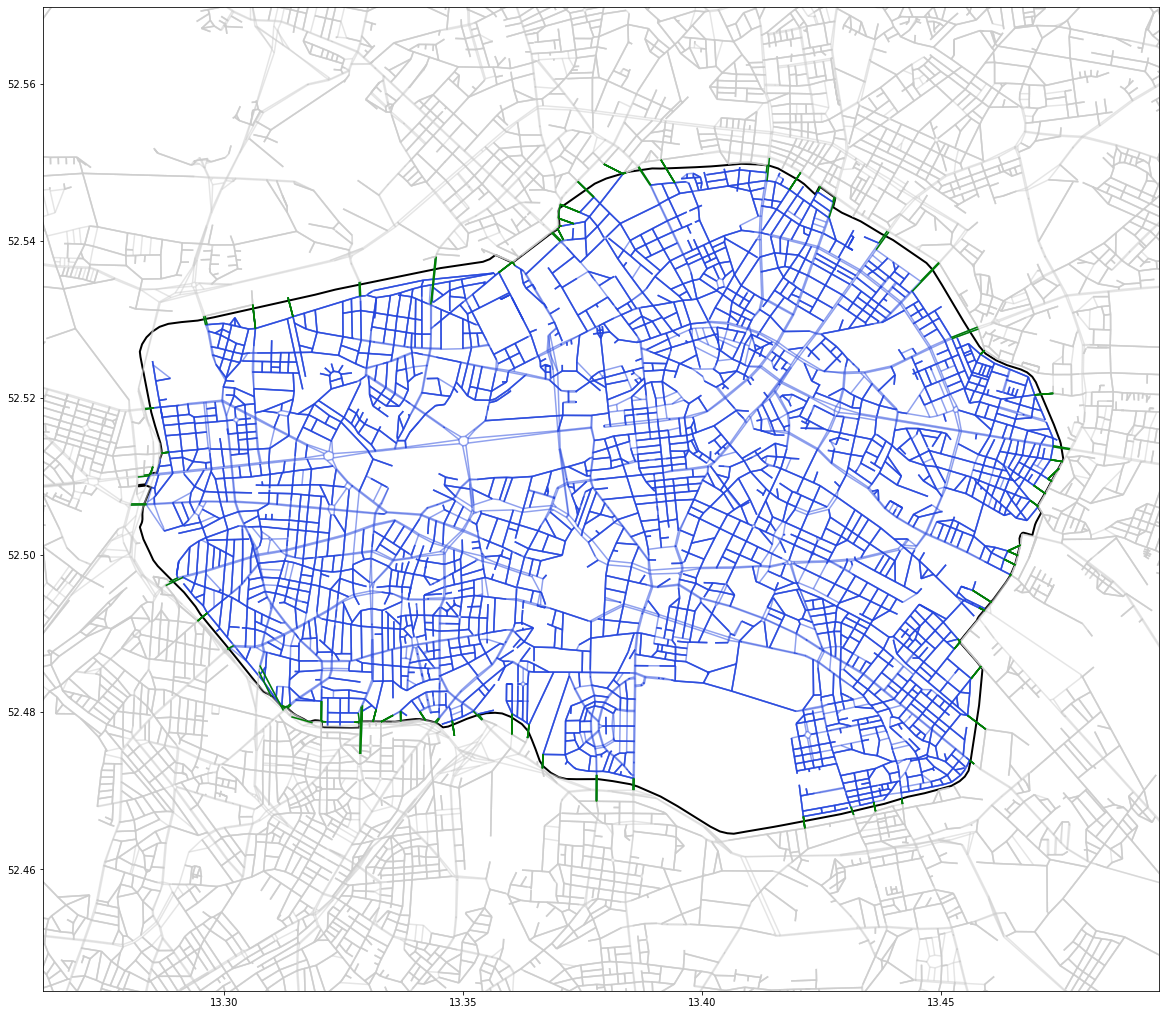

In [27]:

if show_plots:
    fig, ax = plt.subplots(nrows=1, figsize = (20,20))
    inside_road_links.plot(ax=ax, color="#2244dd", alpha=.5)
    sm_outside.road_links.plot(ax=ax, color="#cccccc", alpha=.5)
    inside_outside_connection_links.plot(ax=ax, color='green', linewidth=1.5)
    umweltzone.plot(ax=ax, color="None", edgecolor="black", linewidth=2)
    ax.set_xlim(umweltzone.total_bounds[0]-0.02, umweltzone.total_bounds[2]+0.02)
    ax.set_ylim(umweltzone.total_bounds[1]-0.02, umweltzone.total_bounds[3]+0.02)



## Pathfinding

Next, we want to create a table of OD-relations for different modes, each, being representative for the performance of a specific mode on a specific OD pair.

Quetzal has multiple options for path finding, seperated into one function wrapper for road and one for PT. They create the `car_los` and `pt_los tables`, respectively.

For road transport, quetzal can simply compute one shortest path per OD pair or multiple ones if you had the capacities and volumes already saved in the model (comes from the assignment step at the very end). So, we just compute one path for now (`all_or_nothing=True`)

The PT pathfinder has two relevant attributes: `broken_modes` and `broken_routes`. If both are `False`, the pathfinder just searches for the shortest path between every OD pair, considering all PT modes and routes. If `broken_modes=True`, the pathfinder searches shortest paths for every possible mode combination. If `broken_routes=True`, the pathfinder searches shortest paths for every possible route combination. 
Additionally you can decide whether walking connections shall be done on roadsides or not with the `walk_on_road` parameter (question of computation time).

### Car

In [28]:
# Simple road pathfinder # broken_modes=False, broken_routes=False
sm.step_road_pathfinder(all_or_nothing=True)

# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = sm.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
sm.car_los['length'] = sm.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

# add the route type for sake of consistency
sm.analysis_car_route_type()

sm.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
124926,zone_08010115,zone_10040830,1901.304718,"[zone_08010115, 6556641548, 59905492, 21487237...","[6556641548, 59905492, 21487237, 29789748, 297...","[101117, 73979, 88783, 20257, 20225, 20222, 20...","[(zone_08010115, 6556641548), (269883863, zone...",17060.902,"(car,)",car


In [29]:
# for car free scenario
sm_outside.step_road_pathfinder(all_or_nothing=True)

# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = sm_outside.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
sm_outside.car_los['length'] = sm_outside.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

# add the route type for sake of consistency
sm_outside.analysis_car_route_type()

sm_outside.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
53176,zone_07060604,zone_03061430,2723.768301,"[zone_07060604, 6083315319, 32350268, 32350270...","[6083315319, 32350268, 32350270, 26569513, 265...","[97078, 97080, 74624, 1622, 1617, 48849, 22352...","[(zone_07060604, 6083315319), (29794982, zone_...",22555.819,"(car,)",car


## PT step_pt_pathfinder

In [30]:
# Simple PT
# set broken_modes=False because for our model unique best path matters. no capacity constrained involved anyways.
sm.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=False)


path_analysis: 100%|██████████| 200704/200704 [00:12<00:00, 15649.89it/s]


In [31]:
sm_pt_los, sm_links = sm.pt_los.copy(), sm.links.copy()

## Bike

In [32]:
bike_speed = 16.5#km/h /3.6 #m/s
bk, bk_road_links = sm.copy(), sm.road_links.copy()

# road network excluding high ways etc.
bk_road_links = bk_road_links[bk_road_links['avspeed']/0.7 <= 50]
bk_road_links['walk_time'] = bk_road_links['walk_time'] * 7 / bike_speed # lonleg speed / bike speed, as you dont have to walk to start point.
bk_road_links['time'] = bk_road_links['length'] / (bike_speed/3.6)

bk.road_links = bk_road_links
bk.car_los = bk.car_los.copy()

# Simple road pathfinder # broken_modes=False, broken_routes=False
bk.step_road_pathfinder(all_or_nothing=True)

# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = bk.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
bk.car_los['length'] = bk.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

# add the route type for sake of consistency
bk.analysis_car_route_type()
bk.car_los['route_type'] = 'bike'
bk.car_los['route_types'] = [('bike',) for x in range(len(bk.car_los))]

## rebuild bike object to fit to fit in PT structurem

### rebuild links object for bikes from car_los, road_nodes, (road_links)

In [33]:
bk_links = bk.car_los.copy()

# id names don't match link format (link format use nodes based on stop_ids instead of zone ids) 
bk_links['origin'] = bk_links['origin'] # maybe use node here
bk_links['destination'] = bk_links['destination'] # maybe use nodes here
bk_links['pattern_id'] = 'bike_' + bk_links['origin'] + '_' + bk_links['destination']
bk_links['trip_id'] = bk_links['pattern_id'] + '_0'
bk_links['route_id'] = bk_links['trip_id']

bk_links['a'] = bk_links['origin']
bk_links['b'] = bk_links['destination']
bk_links['road_node_list'] = bk_links['node_path']
bk_links['road_links_list'] = bk_links['link_path'] 

bk_links['road_a'] = [x[0] if len(x)>0 else None for x in bk_links['road_node_list']]
bk_links['road_b'] = [x[-1] if len(x)>0 else None for x in bk_links['road_node_list']]

bk_links['duration'] = bk_links['time']

# make geometry LineString connecting all road_nodes (not precisely mapping on road)
# bk_links['geometry'] = [LineString([bk.road_nodes.loc[l].geometry for l in node_path ]) for node_path in bk_links['node_path']] 
# save time by just using straight line connection
bk_links['geometry'] = [LineString([bk.road_nodes.loc[l].geometry for l in [node_path[0], node_path[-1]] ]) if len(node_path)>0 else LineString([]) for node_path in bk_links['node_path']] 

bk_links['link_sequence'] = [len(x) for x in bk_links['road_links_list']] # unsure about that one.

bk_links['headway'] = 0 # set to number so that headway is super small. you can always start your bike trip
bk_links['cost'] = bk_links['time'] # cost = time + .5 * headway

bk_links['route_type'] = 'bike'

bk_links['service_id'] = 0
bk_links['direction_id'] = 1
bk_links['agency_id'] = 0
bk_links['color'] = None

bk.links = bk.links[0:0] # clear previous links
bk.links = bk.links.append(bk_links)
bk.links.index = 'bike_' + bk.links.index.astype(str).values


### rebuild pt_los object for bikes from car_los, road_nodes, (road_links)


In [34]:
bike_los = bk.car_los # .copy()

bike_los['gtime'] = bike_los['time']

bike_links_t_id_dict = dict([(t_id, i) for i, t_id in zip(bk_links.index, bk_links['trip_id'].values)])
bike_los['link_path'] = [['bike_' + str(bike_links_t_id_dict['bike_' + o + '_' + d + '_0'])] if o != d else [] for o,d in zip(bike_los['origin'].values, bike_los['destination'].values)]
# bike_los['link_path'] = [['bike_' + str(l) for l in p] for p in bike_los['link_path']]

# bike_los['route_type'] = 'bike'
# bike_los['route_types'] = (bike_los['route_type'],)

bike_los['reversed'] = False
bike_los['pathfinder_session'] = 'mode_breaker'

bike_los['broken_modes'] = [{} for x in range(len(bike_los))]
bike_los['boardings'] = [[] for x in range(len(bike_los))]
bike_los['alightings'] = [[] for x in range(len(bike_los))]
bike_los['transfers'] = [[] for x in range(len(bike_los))]
bike_los['boarding_links'] = [[] for x in range(len(bike_los))]
bike_los['alighting_links'] = [[] for x in range(len(bike_los))]
bike_los['ntlegs'] = [[] for x in range(len(bike_los))]
bike_los['footpaths'] = [[] for x in range(len(bike_los))]

bike_los['all_walk'] = False
bike_los['ntransfers'] = 0


bike_los['time_link_path'] = bike_los['time']
bike_los['length_link_path'] = bike_los['length']

# bike_los['footpaths'] = (sm.zone_to_road[sm.zone_to_road['a']==a] for a in bike_los['a'])

bike_los.index = 'bike_' + bike_los.index.astype(str).values

### join bike to pt tables

In [35]:
sm.pt_los = sm_pt_los
# append bike type to pt_los
clmns = [x for x in sm.pt_los.columns if x in bike_los.columns]
print(clmns)
if 'route_type' in clmns:
    sm.pt_los = sm.pt_los[sm.pt_los['route_type'] != 'bike']
sm.pt_los = sm.pt_los.append(bike_los[clmns])

# append bike type and to links
sm.links = sm.links[sm.links['route_type'] != 'bike']
sm.links = sm.links.append(bk.links)

print(len(sm.pt_los))
# 2 130 868
# 2 130 247

['origin', 'destination', 'gtime', 'path', 'pathfinder_session', 'reversed', 'boardings', 'alightings', 'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers', 'boarding_links', 'alighting_links', 'all_walk', 'ntransfers', 'time_link_path', 'length_link_path']
398732


### get pt statistics

In [36]:
sm.links['route_type'].unique()
# to-do bikes need to be added to links!

array(['bus', 'rail', 'tram', 'subway', 'bike'], dtype=object)

In [37]:
# Add route types to the paths
# The mode that appears first in the hierarchy is assigned as
# main mode, if there is more than one route_type used on the path
hierarchy = ['bike', 'rail', 'subway', 'funicular', 'tram', 'bus']
sm.analysis_pt_route_type(hierarchy)

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

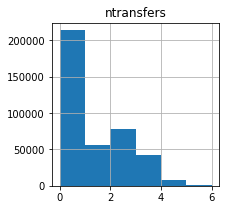

In [38]:
# How many transfers do we have?
sm.pt_los.hist(column='ntransfers', bins=sm.pt_los['ntransfers'].max(), figsize=(3,3))

In [39]:
#('bus',) in  
sm.pt_los['route_types'].unique()

array([(), ('subway', 'bus'), ('bus',), ('rail', 'bus'),
       ('tram', 'rail', 'bus'), ('subway', 'rail', 'bus'),
       ('subway', 'tram', 'bus'), ('subway', 'tram', 'rail', 'bus'),
       ('subway',), ('rail',), ('subway', 'rail'), ('tram', 'rail'),
       ('subway', 'tram', 'rail'), ('subway', 'tram'), ('tram', 'bus'),
       ('tram',), ('bike',)], dtype=object)

<AxesSubplot:xlabel='route_types'>

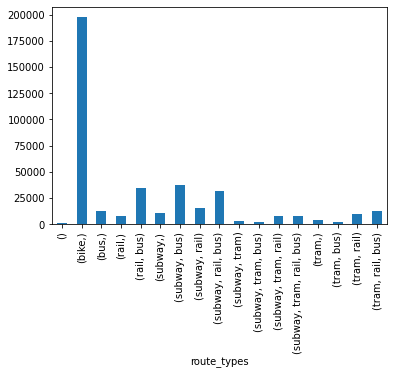

In [40]:
# How many connections do we have per mode combination in the shortest paths?
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

In [41]:
# Now, let's look at the results when we disaggregate paths by route_type
# sm.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=False)

In [42]:
# How many paths do we have now compared to 12,100 before?
len(sm.pt_los)

398732

In [43]:
sm.analysis_pt_route_type(hierarchy)
sm.pt_los.sample()

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type
58445,zone_04030724,zone_06010103,1941.960224,"(zone_04030724, n_node_de:11000:900024106:1:51...",best_path,False,"[n_node_de:11000:900024106:1:51, n_node_de:110...","[n_node_de:11000:900044202:1:51, n_node_de:110...","[n_node_de:11000:900024106:1:51, n_node_de:110...","[link_747, link_748, link_749, link_750, link_...",...,"[(zone_04030724, n_node_de:11000:900024106:1:5...",[],"[link_747, link_12206]","[link_751, link_12208]",False,1,654.0,8797.0,"(subway, rail)",rail


<AxesSubplot:xlabel='route_types'>

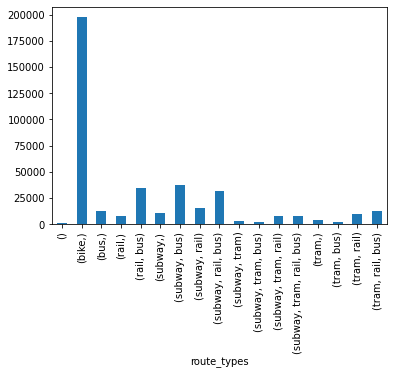

In [44]:
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

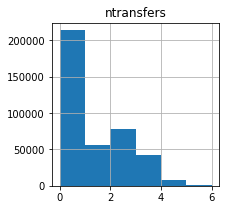

In [45]:
# How many transfers do we have?
sm.pt_los.hist(column='ntransfers', bins=6, figsize=(3,3))

In [46]:
sm.pt_los.tail(2)

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type
bike_200702,zone_12304314,zone_12304313,486.336261,"[zone_12304314, 168209206, 168209213, 24871861...",mode_breaker,False,[],[],"[168209206, 168209213, 248718618, 338891124, 1...",[bike_200702],...,[],[],[],[],False,0,486.336261,1779.592,"(bike,)",bike
bike_200703,zone_12304314,zone_12304314,0.000000,[zone_12304314],mode_breaker,False,[],[],[],[],...,[],[],[],[],False,0,0.000000,0.000,(),bus


In [47]:
sm.pt_los.head(2)


,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type
0,zone_01011101,zone_01011101,0.000000,"(zone_01011101,)",best_path,False,[],[],[],[],...,[],[],[],[],True,0,0.0,0.00,(),bus
1,zone_01011101,zone_01011102,1531.562745,"(zone_01011101, n_node_de:11000:900005101::1, ...",best_path,False,"[n_node_de:11000:900005101::1, n_node_de:11000...","[n_node_de:11000:900023201::6, n_node_de:11000...","[n_node_de:11000:900005101::1, n_node_de:11000...","[link_5919, link_5920, link_12185]",...,"[(zone_01011101, n_node_de:11000:900005101::1)...",[],"[link_5919, link_12185]","[link_5920, link_12185]",False,1,360.0,2535.32,"(subway, bus)",subway


In [48]:
# Compute time attribute (from link path and footpaths and access links)
sm.analysis_pt_time()

In [49]:
# Closer look at one OD pair
sm.pt_los.loc[(sm.pt_los['origin']=='zone_11') & (sm.pt_los['destination']=='zone_99')][
    ['route_types', 'time', 'ntransfers']]

,route_types,time,ntransfers


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


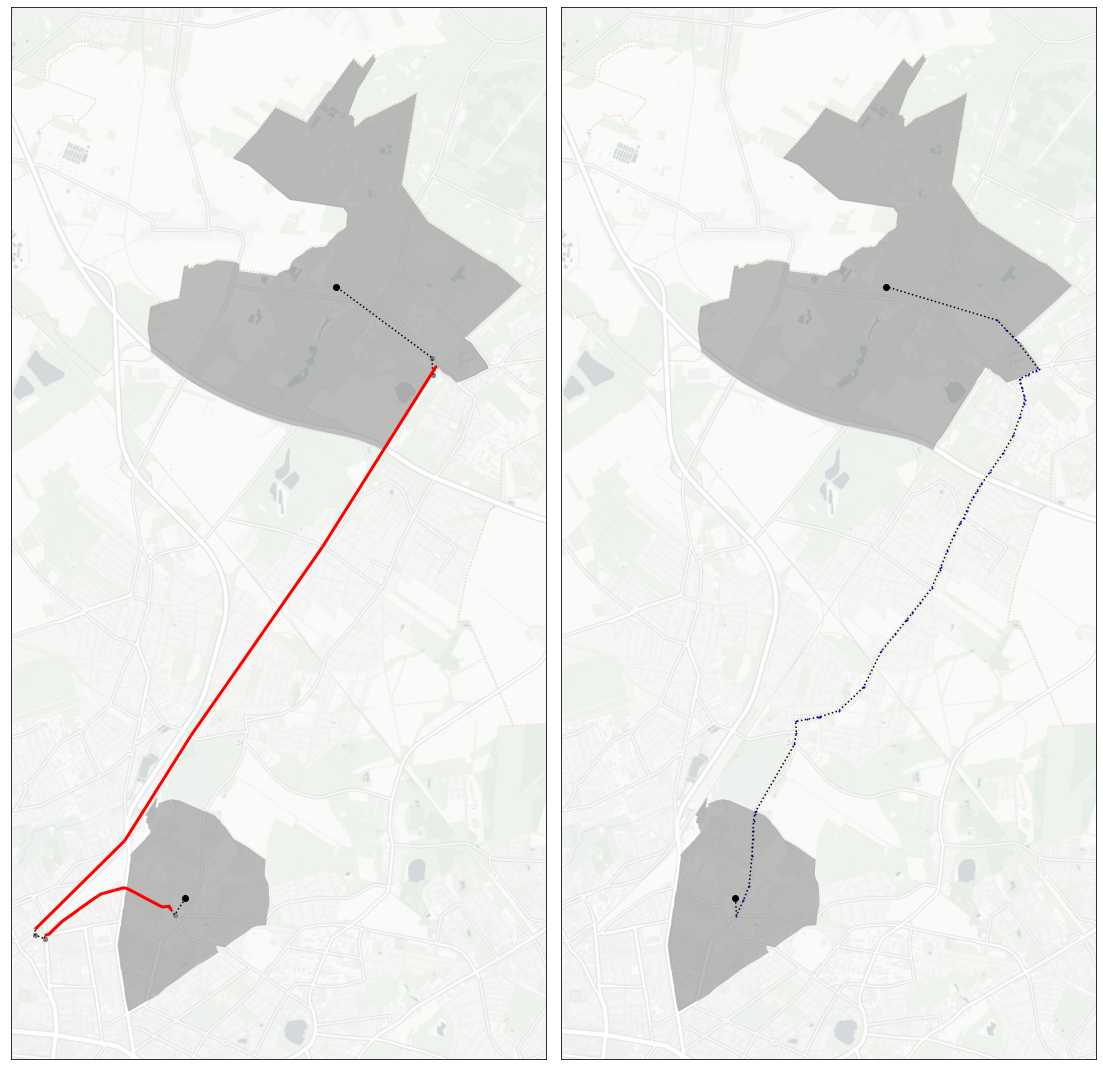

In [50]:
# Plot
if show_plots:
    plot = sm.change_epsg(3857, coordinates_unit=sm.coordinates_unit)
    plot.links['color'] = '#' + plot.links['route_color']
    fig, axes = plot.plot_separated_paths(
        sm.zones.index[77%len(sm.zones)], sm.zones.index[67%len(sm.zones)], rows=1, figsize=[16, 16],
        title=None, constrained_layout=True, zoom=13, resize=True,
        basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', 
    )

In [51]:
# Assign a length to LoS table
sm.analysis_pt_length()

<AxesSubplot:>

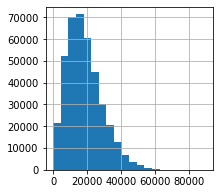

In [52]:
# Length distribution
sm.pt_los['length'].hist(bins=20, figsize=(3,3))

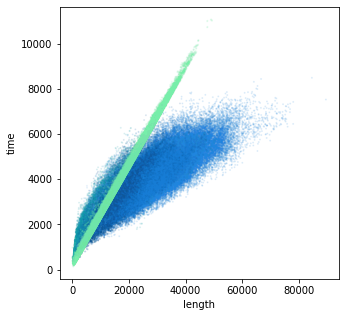

In [53]:
# Dependency between distance and time
mask = sm.pt_los['origin']!=sm.pt_los['destination'] # Filter statement
color_dict = {'bus': '#129eac', 'subway': '#0e5899', 'tram': '#5ea8e8', 'rail': '#1F85DE', 'walk': '#adb3b4', 'bike': '#77eeaa'}
color_list = [color_dict[t] for t in sm.pt_los.loc[mask, 'route_type']]
ax = sm.pt_los.loc[mask].plot(
    kind='scatter', x='length', y='time', figsize=[5, 5], s=1, c=color_list, alpha=.1, legend=True)

In [54]:
sm.zones.index[77%len(sm.zones)], sm.zones.index[67%len(sm.zones)]

('zone_03030715', 'zone_03010101')

In [55]:
# Plot all paths between zones including car
if show_plots:
    path(sm, sm.zones.index[77%len(sm.zones)], sm.zones.index[67%len(sm.zones)], public=True, private=True)

## append both scenarios to car_los

In [56]:
sm_outside.car_los['scenario'] = 'car_free'
sm_outside.car_los.index = 'car_free_' + sm_outside.car_los.index.astype(str).values
sm.car_los['scenario'] = 'cars'
sm.car_los = sm.car_los.append(sm_outside.car_los)

## Save model

In [57]:
sm.pt_los.reset_index(drop=True, inplace=True)

In [58]:
# run_both = True

In [59]:
if not run_both:
    sm.to_json(model_path + 'los_tables')

In [60]:
if not run_both:
    raise("Stop here. run_both:"+str(run_both))

In [61]:
show_plots = True
car_free = False

In [62]:
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from shapely.ops import unary_union
import numpy as np
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
from datetime import datetime
import math


In [63]:
# Load the model with LoS tables from the last exercise
input_path = '../input/'
model_path = '../model/'


In [64]:
if not run_both:
    sm = stepmodel.read_json(model_path + 'los_tables')

In [65]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:", broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: []
Successfully fixed.


In [66]:
# save car_los to differentiate for scenarios later on
sm_car_los = sm.car_los.copy()
# sm.car_los = sm_car_los

## Add demographic information

### population by zone, age and gender

In [67]:
age = pd.read_excel(input_path + 'zone_stats/sbb_plr_alter5Jahre.xlsx', index_col=0)
age_sex = pd.read_excel(input_path + 'zone_stats/sbb_plr_alter5Jahre_geschlecht.xlsx', header=[0,1], index_col=0)

age_groups = list(age.columns)
genders = [x[1] for x in age_sex.columns][:2]
age_gender_groups = [item for sublist in [[(age_group, gender) for gender in genders ]for age_group in age_groups] for item in sublist]

# recode to percentage of zone population
age_sex[age_gender_groups] = age_sex[age_gender_groups].replace('-', 0)
age_gender_totals = [age_sex.iloc[n][age_gender_groups].sum() for n in range(len(age_sex))]
# set as percentage
age_sex[age_gender_groups] = [age_sex.iloc[n][age_gender_groups]/age_gender_totals[n] for n in range(len(age_sex))]

age_sex.head(2)

Alter in 5-Jahresschritten   unter 5           5 bis unter 10            \
Geschlecht                  männlich  weiblich       männlich  weiblich   
1011101                     0.019304  0.019304       0.015209  0.013454   
1011102                     0.015625  0.015625       0.000000  0.000000   

Alter in 5-Jahresschritten 10 bis unter 15           15 bis unter 20  \
Geschlecht                        männlich  weiblich        männlich   
1011101                           0.012284  0.007897        0.006727   
1011102                           0.015625  0.015625        0.020833   

Alter in 5-Jahresschritten           20 bis unter 25            ...  \
Geschlecht                  weiblich        männlich  weiblich  ...   
1011101                     0.011407        0.035390  0.029541  ...   
1011102                     0.000000        0.046875  0.020833  ...   

Alter in 5-Jahresschritten 75 bis unter 80           80 bis unter 85  \
Geschlecht                        männlich  weiblich        männlich   
1011101                           0.026908  0.026031        0.019889   
1011102                           0.031250  0.000000        0.015625   

Alter in 5-Jahresschritten           85 bis unter 90            \
Geschlecht                  weiblich        männlich  weiblich   
1011101                     0.021351        0.006435  0.008482   
1011102                     0.031250        0.000000  0.000000   

Alter in 5-Jahresschritten 90 bis unter 95          95 und mehr           
Geschlecht                        männlich weiblich    männlich weiblich  
1011101                           0.001755  0.00351    0.001755      0.0  
1011102                           0.000000  0.00000    0.000000      0.0  

[2 rows x 40 columns]

### number of trips per age group

In [68]:
anzahl_wege_alter15 = pd.read_excel(input_path + 'transport_stats/anzahl_wege_alter15.xlsx', index_col=0)
anzahl_wege_alter15['age_groups'] = [[] for x in range(len(anzahl_wege_alter15))]
anzahl_wege_alter15['age_groups'].iloc[0] = age_groups[0:3]
anzahl_wege_alter15['age_groups'].iloc[1] = age_groups[3:5]
anzahl_wege_alter15['age_groups'].iloc[2] = age_groups[5:9]
anzahl_wege_alter15['age_groups'].iloc[3] = age_groups[9:13]
anzahl_wege_alter15['age_groups'].iloc[4] = age_groups[13:]

anzahl_wege_alter15[0:5]

,männlich,Ungew. Fallzahl,weiblich,Ungew. Fallzahl.1,Alle,Ungew.Fallzahl,Mobilität in Städten – SrV 2018,age_groups
Altersgruppe,,,,,,,,
0 bis unter 15 Jahre,3.0,3.321,3.0,3.448,3.0,6.769,Berlin,"[unter 5, 5 bis unter 10, 10 bis unter 15]"
15 bis unter 25 Jahre,3.2,1.328,3.3,1.330,3.2,2.658,Tab 6.1,"[15 bis unter 20, 20 bis unter 25]"
25 bis unter 45 Jahre,3.7,4.577,3.9,5.219,3.8,9.796,Wochentag: Mittlerer Werktag,"[25 bis unter 30, 30 bis unter 35, 35 bis unte..."
45 bis unter 65 Jahre,3.5,4.973,3.6,5.390,3.6,10.363,Berechnet am: 15.11.2019,"[45 bis unter 50, 50 bis unter 55, 55 bis unte..."
65 Jahre und älter,3.3,4.175,3.2,4.346,3.3,8.521,Zeitraum: Gesamtes Jahr,"[65 bis unter 70, 70 bis unter 75, 75 bis unte..."


In [69]:
alter_geschlecht_wegzweck = pd.read_excel(input_path + 'transport_stats/alter_geschlecht_wegzweck.xlsx', header=[0,1], index_col = 0)
alter_geschlecht_wegzweck

unter 10          10 bis unter 20          20 bis unter 30  \
Zweck         männlich weiblich        männlich weiblich        männlich   
Accompaniment       22       22               4        4               3   
Leisure             34       34              40       39              26   
Errands              4        4               8        8              11   
Shopping             5        5               5        8              12   
Education           34       35              36       35               8   
Business             0        0               2        2              15   
Work                 0        0               5        4              26   

                       30 bis unter 40          40 bis unter 50           \
Zweck         weiblich        männlich weiblich        männlich weiblich   
Accompaniment        7               7       20               7       15   
Leisure             31              21       24              20       23   
Errands             13              11       12              11       13   
Shopping            13              12       15              12       16   
Education            7               1        1               0        1   
Business             8              20        9              24        9   
Work                22              28       20              26       23   

              50 bis unter 60          60 bis unter 70           \
Zweck                männlich weiblich        männlich weiblich   
Accompaniment               4        5               5        5   
Leisure                    19       24              27       30   
Errands                    12       16              21       23   
Shopping                   14       19              22       25   
Education                   0        0               0        0   
Business                   26       11              13        6   
Work                       25       24              12       11   

              70 bis unter 80          80 und mehr                       
Zweck                männlich weiblich    männlich weiblich       Zweck  
Accompaniment               5        3           3        2  Begleitung  
Leisure                    34       36          33       36    Freizeit  
Errands                    29       27          32       29  Erledigung  
Shopping                   28       31          30       31     Einkauf  
Education                   0        0           0        0  Ausbildung  
Business                    2        1           1        0  dienstlich  
Work                        2        1           1        1      Arbeit

In [70]:
wege_zweck_poiskeys = pd.read_excel(input_path + 'transport_stats/wege_zweck_poiskeys.xlsx', index_col=0)[:11]
wege_zweck_poiskeys

,Binnenverkehr,QuellundZielverkehr,AlleWege,Wegzweck,km_Wegzweck,POI-keys,Ziel/Zweck deutsch,Wegzweck deutsch,Unnamed: 9,Unnamed: 10
Ziel/Zweck,,,,,,,,,,
Education,6.6,3.0,6.3,Education;Accompaniment,7.5,kindergarten;school;university;college,Summe Schule,Ausbildung;Begleitung,NaN,NaN
Shopping,11.4,6.6,11.2,Shopping,5.0,pharmacy;marketplace;retail;hardware;garden_ce...,Summe Einkauf,Einkauf,NaN,NaN
Own workplace,13.1,18.3,13.4,Work,12.0,NaN,Eigener Arbeitsplatz,Arbeit,NaN,NaN
Other place of work/route,2.1,6.9,2.5,Work,18.0,NaN,Anderer Dienstort/-weg,Arbeit,NaN,NaN
"Visit to authorities, doctor",3.2,1.4,3.1,Errands,10.0,doctors;clinic;hospital,Behördengang. Arztbesuch,Erledigung,NaN,NaN
Service facility (e.g. post office. bank. hairdresser),2.5,1.1,2.4,Errands,10.0,roofer;electronics_repair;beekeeper;joiner;pri...,Dienstleistungseinrichtung (z. B. Post. Bank. ...,Erledigung,NaN,NaN
"Culture, theater, cinema",0.7,0.3,0.7,Leisure,15.0,cinema;arts_centre;theatre;nightclub;events_venue,Kultur. Theater. Kino,Freizeit,NaN,NaN
Restaurant/pub/cafe,3.1,1.5,3.2,Leisure,15.0,restaurant;biergarten;cafe;pub;bar;icecream;ho...,Gaststätte/Kneipe,Freizeit,NaN,NaN
"Recreation, Sports",8.7,9.7,8.9,Leisure,15.0,community_centre;public_bath;stadium;beach_res...,Summe Sport Freizeit,Freizeit,NaN,NaN


In [71]:
# create dictonary to look up age x gender groups and there respective number of daily trips
age_gender_dict = dict([(x,dict([(g,[]) for g in genders])) for x in age_groups])
age_10_groups =  [x[0] for x in alter_geschlecht_wegzweck.columns]
for n, age_group in enumerate(age_groups):
    age_group_ind = [n for n, x in enumerate(list(anzahl_wege_alter15['age_groups'])) if age_group in x][0]
    age_gender_dict[age_group]['age_10_group']  = age_10_groups[n] if n < len(age_10_groups) else age_10_groups[-1]
    for gender in genders:
        age_gender_dict[age_group][gender] = anzahl_wege_alter15[gender].iloc[age_group_ind]

# print(age_gender_dict)


In [72]:
# use data on strecke wegzweck to make good impedance matrix
strecke_wegzweck = pd.read_excel(input_path + 'transport_stats/strecke_wegzwecke_mid17_t9.xlsx', index_col = 0)

trip_purposes = strecke_wegzweck.index.values

strecke_wegzweck

,km,Quelle,Wegzweck.1,Unnamed: 4,Unnamed: 5,Unnamed: 6
Wegzweck,,,,,,
Work,12,MiD 2017,Arbeit,NaN,NaN,NaN
Business,18,Tabelle 9,dienstlich,NaN,NaN,NaN
Education,7,durchschnittliche Wegelämgen in Metropolen,Ausbildung,NaN,NaN,NaN
Shopping,5,NaN,Einkauf,NaN,NaN,NaN
Errands,10,NaN,Erledigung,NaN,NaN,NaN
Leisure,15,NaN,Freizeit,NaN,NaN,NaN
Accompaniment,8,NaN,Begleitung,NaN,NaN,NaN


In [73]:
modalsplit_prozent_wege_berlin = pd.read_excel(input_path + 'transport_stats/modalsplit_prozent_wege_berlin.xlsx', index_col=0)
modalsplit_prozent_wege_berlin = modalsplit_prozent_wege_berlin[['Alle Wege']]/100
modalsplit_prozent_wege_berlin

,Alle Wege
Hauptverkehrsmittel,
walk,0.296
bike,0.176
car,0.259
bus,0.046
subway,0.083
tram,0.025
rail,0.108
taxi,0.003
others,0.004


In [74]:
## DATA ABOUT CAR OWNERSHIP WITHIN EACH ZONE IF POSSIBLE

## Step trip generation
In every zone we need to generate a column `emission` and `attraction`. What kind of trips you count to it largely affects the interpretability of your results. If you use employment characteristics only for attraction, your model will only be applicable to commuting questions, but not for shopping or leisure trips. Moreover, the results of a congestion analysis after the assignment step are worthless because the real network load is higher when you consider all demand segments.



In [75]:
sm.zones['total_emissions'] = 0
sm.zones['total_attractions'] = 0


age_sex_index_dict = dict([(x, list(age_sex.index).index(x)) for x in sm.zones['broker Dow'].astype(int).values])
emission_list, attraction_list, _factors = [], [], []
for trip_purpose in trip_purposes:
    print(trip_purpose)
    # create emission per trip_purpose per zone
    purpose_age_gender = alter_geschlecht_wegzweck[alter_geschlecht_wegzweck.index == trip_purpose].iloc[0]
    emission_clmn = 'em_'+trip_purpose
    emission_list.append(\
        [\
            sm.zones.loc[i]['pop'] * \
            sum(\
                [sum([age_sex.iloc[age_sex_index_dict[bd]][(age_group,gender)]*age_gender_dict[age_group][gender] * \
                purpose_age_gender[(age_gender_dict[age_group]['age_10_group'], gender)]/100 for gender in genders]) \
                for age_group in age_groups]\
            ) \
        for i, bd in zip(sm.zones.index.values, sm.zones['broker Dow'].astype(int).values)])
    
    sm_zones_emission_clmn = emission_list[-1]
    
    # create attraction per trip_purpose per zone
    attraction_clmn = 'at_'+trip_purpose
    
    sm_zones_attraction_clmn = [0 for x in sm_zones_emission_clmn]
    
    if trip_purpose in ['Work', 'Business']: # only work or business and work? 
        sm_zones_attraction_clmn = sm.zones['emp']
    else:
        purpose_arr = ['Education', 'Accompaniment', 'Leisure'] if trip_purpose=='Accompaniment' else [trip_purpose]
        if any([x in purpose_arr for x in ['Education', 'Accompaniment']]):
            purpose_arr.append('Education;Accompaniment')

        purpose_mult = .2 if trip_purpose=='Accompaniment' else .8 if  trip_purpose=='Education' else .8 if  trip_purpose=='Leisure' else 1

        poi_purposes = wege_zweck_poiskeys.index.values[[z in purpose_arr for z in wege_zweck_poiskeys['Wegzweck']]]
        
        for poi_purpose in poi_purposes:
            if poi_purpose in sm.zones.columns:        
                sm_zones_attraction_clmn += sm.zones[poi_purpose] * purpose_mult
            else: print("poi_purpose not found:", poi_purpose)
    
    # make sure total attraction equal total emission
    _factor = sum(sm_zones_emission_clmn)/sum(sm_zones_attraction_clmn)
    _factors.append(_factor)
    sm_zones_attraction_clmn = sm_zones_attraction_clmn * _factor

    attraction_list.append(sm_zones_attraction_clmn)

    sm.segments = ['car_owner', 'pt_captive']
    car_ownership_rate = 0.326  #* (12/365 if car_free else 1)
    sm.zones['car_ownership'] = [car_ownership_rate for x in sm.zones.index.values] # To-Do: replace with demographic data #

    sm.zones[('car_owner', emission_clmn)] = [e*o for e,o in zip(sm_zones_emission_clmn, sm.zones['car_ownership'].values)]
    sm.zones[('pt_captive', emission_clmn)] = [e*(1-o) for e,o in zip(sm_zones_emission_clmn, sm.zones['car_ownership'].values)]
    sm.zones[('car_owner', attraction_clmn)] = [a*o for a,o in zip(sm_zones_attraction_clmn, sm.zones['car_ownership'].values)]
    sm.zones[('pt_captive', attraction_clmn)] = [a*(1-o) for a,o in zip(sm_zones_attraction_clmn, sm.zones['car_ownership'].values)]

    # Cast columns to integer
    sm.zones[('car_owner', emission_clmn)] = sm.zones[('car_owner', emission_clmn)].astype(int)
    sm.zones[('car_owner', attraction_clmn)] = sm.zones[('car_owner', attraction_clmn)].astype(int)
    sm.zones[('pt_captive', emission_clmn)] = sm.zones[('pt_captive', emission_clmn)].astype(int)
    sm.zones[('pt_captive', attraction_clmn)] = sm.zones[('pt_captive', attraction_clmn)].astype(int)

    sm.zones['total_emissions'] += sm_zones_emission_clmn
    sm.zones['total_attractions'] += sm_zones_attraction_clmn
    
    
    print(trip_purpose, _factor)

    # if trip_purpose == 'Work': # add return trips

    


Work
Work 1.3661079807626628
Business
Business 0.8780498749042503
Education
Education 1.4111048480891517
Shopping
Shopping 1.5089482120621303
Errands
Errands 2.807861344128047
Leisure
poi_purpose not found: Own apartment
Leisure 2.8514626286829294
Accompaniment
poi_purpose not found: Own apartment
Accompaniment 2.3573493872705193


## Scenarios and Prices

Add price LoS attribute to LoS tables

In [145]:
# set scenario variable
car_free = False

In [146]:
# For PT, we have a look at the PT operators price structure.
# For this toy model we simplify it to day tickets:
# https://www.ratp.fr/en/titres-et-tarifs/mobilis
# Assume that a passenger makes two trips per day with a day ticket
sm.pt_los['price'] = 7.5 / 2 / 4#7.5 / 2
# We don't re-build the exact price structure, but make longer trips more expensive
sm.pt_los.loc[sm.pt_los['length']>10000, 'price'] = 7.5 / 2 / 4 * 1.5 #10 / 2
# sm.pt_los['price'][sm.pt_los['route_type']=='bike'] = sm.pt_los['length'][sm.pt_los['route_type']=='bike'] / 1000 * 0.2

In [147]:
sm.car_los = sm_car_los.copy()
print('car_free:', car_free)
if not car_free:

    sm.car_los = sm.car_los[sm.car_los['scenario'] != 'car_free']
    # Car usage has operating cost of 12ct/km in average
    # Note: we don't apply sunk cost like maintenance or purchase cost
    sm.car_los['price'] = sm.car_los['length'] * 0.12 / 1000
else:
    ## cap price
    cap_price_base = 3.9
    cap_price_short_km = 2.3
    cap_price_long_km = 1.65
    cap_threshold_long = 7000

    sm.car_los['price'] = \
        min(sm.car_los['length'], cap_threshold_long) * cap_price_short_km + \
        max(0, sm.car_los['length']-cap_threshold_long)*cap_price_long_km
    
    sm.car_los[sm.car_los['scenario'] != 'car_free'] = \
        sm.car_los[sm.car_los['scenario'] != 'car_free']['length'] * 0.12 / 1000



car_free: False


## Step distribution

Once we have emission and attraction, we want to know the volumes per OD-pair. We can use the `step_distribution` function from quetzal. It uses the doubly constrained distribution (no probabilistic Logit approach), which is an iterative process where emissions and attractions are matched so that, on average, the minimal resistance for the whole system is found. Talking about resistance: an important input parameter is the impedance matrix, giving resistances between every OD-pair. Resistance can be time, but also cost or other utility/disutility quantifications.

Calibration of this step (not performed in this toy model) requires to change emission and attraction values or the impedance matrix

To-Do:
- check for distance travelled per inhabitant (compare to survey data)
- do we have transport data on district level or so?
- plot graphs for OD Matrix
- FRATAR algorithm, do we use it? Do we have to understand it?
- number is too small in relation to trips outside of zone. what has to be done?
- sometimes zones still have an above average connection to another zone even if its on the other side of the city. Whats the reason? What should be done?
- maybe stadtaubahn is treated as too slow in relation to other routes?

In [148]:
# Now, we need an impedance matrix for car and PT, respectively.
# Use time as resistance value, but distance or cost are thinkable, too
car_imp_matrix = sm.car_los[['origin', 'destination', 'time']].set_index(
    ['origin','destination']).unstack()
# Assign a resistance for staying in the home cell
car_imp_matrix = car_imp_matrix.replace(0, 60*4)
car_imp_matrix.head(2)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    240.000000    537.149979    338.121859    450.669491   
zone_01011102    538.545614    240.000000    618.826332    751.105084   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101    348.592440    499.415025    669.981235    605.730971   
zone_01011102    597.438593    726.091589    841.390055    812.593820   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101    644.618814    578.006559  ...   1611.289251   1821.144598   
zone_01011102    871.295378    735.369614  ...   1659.868432   1869.723778   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101   1382.707846   1696.643968   1683.362333   1589.344361   
zone_01011102   1431.287027   1745.223148   1731.941513   1637.923541   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   1516.594284   1692.911379   1281.725025   1436.090461  
zone_01011102   1565.173464   1741.490560   1341.705542   1496.070979  

[2 rows x 448 columns]

In [149]:
# In the PT case we have to take the minimum time per OD pair,
# because we have multiple routes
pt_imp_matrix = sm.pt_los.groupby(
    ['origin', 'destination']).agg({'time': 'min'}).unstack()

pt_imp_matrix = pt_imp_matrix.replace(0, 60*4)
pt_imp_matrix.head(2)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    240.000000     577.64106    451.319001    594.269088   
zone_01011102    578.713642     240.00000    731.736882    874.686969   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101    557.632859    773.802018   1041.275694    941.639217   
zone_01011102    816.049503   1018.166226   1208.280137   1186.003425   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101    977.550278    960.327561  ...   3032.954104   3363.731353   
zone_01011102   1221.914487   1092.988822  ...   2924.124311   3254.901560   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101   2689.627509   3144.498138   3031.906433   2930.661889   
zone_01011102   2578.277086   2805.625335   2840.819696   2821.832096   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   2858.830145   3192.100097   2660.554232   2873.200191  
zone_01011102   2750.000352   3031.022959   2551.724439   2764.370397  

[2 rows x 448 columns]

### use different weighting of impedance matrix for different trip purposes 
(e.g. stronger decay over distance for shopping than for work)

In [150]:

# make deterence matrix parameters depndent on average trip length
mult_shift = \
    dict([\
            (trip_purpose, dict([\
                ('km', strecke_wegzweck['km'].loc[trip_purpose]), \
                ('_mult', 1/ (8000.0*1.0 + 0.01 * 1000 * strecke_wegzweck['km'].loc[trip_purpose]) ), \
                ('_exp',5), \
                ('_shift',0.0)\
            ]))\
    for trip_purpose in trip_purposes])
mult_shift

{'Work': {'km': 12, '_mult': 0.00012481278082875687, '_exp': 5, '_shift': 0.0},
 'Business': {'km': 18,
  '_mult': 0.0001247193813918683,
  '_exp': 5,
  '_shift': 0.0},
 'Education': {'km': 7,
  '_mult': 0.00012489072061945796,
  '_exp': 5,
  '_shift': 0.0},
 'Shopping': {'km': 5,
  '_mult': 0.00012492192379762648,
  '_exp': 5,
  '_shift': 0.0},
 'Errands': {'km': 10,
  '_mult': 0.00012484394506866417,
  '_exp': 5,
  '_shift': 0.0},
 'Leisure': {'km': 15,
  '_mult': 0.00012476606363069246,
  '_exp': 5,
  '_shift': 0.0},
 'Accompaniment': {'km': 8,
  '_mult': 0.00012487512487512488,
  '_exp': 5,
  '_shift': 0.0}}

car_owner
pt_captive
work
car_owner
pt_captive
car_owner
pt_captive
car_owner
pt_captive
car_owner
pt_captive
car_owner
pt_captive
car_owner
pt_captive


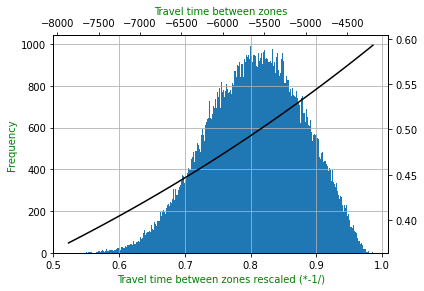

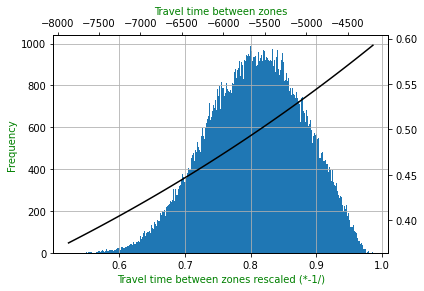

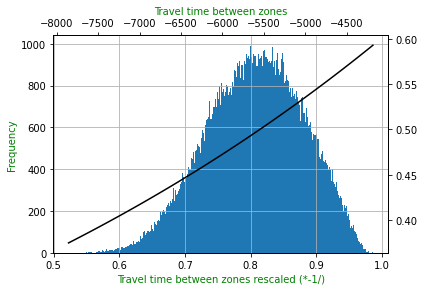

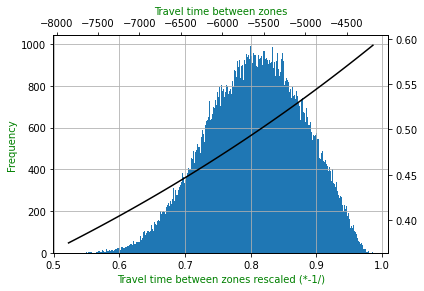

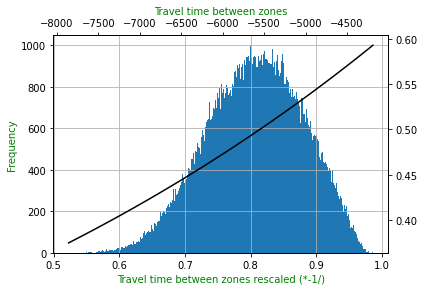

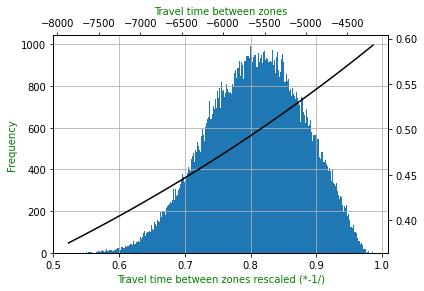

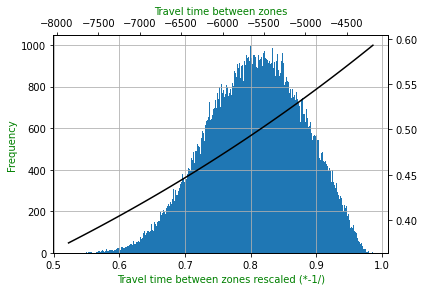

In [151]:
od_volumes = {}

for trip_purpose in trip_purposes:
    
    car_imp_matrix_inv = math.e**(car_imp_matrix*-1*mult_shift[trip_purpose]['_mult']+mult_shift[trip_purpose]['_shift'])
    pt_imp_matrix_inv = math.e**(pt_imp_matrix*-1*mult_shift[trip_purpose]['_mult']+mult_shift[trip_purpose]['_shift'])

    deterrence_matrix =  {'car_owner': car_imp_matrix_inv,
                        'pt_captive': pt_imp_matrix_inv}
    distr_params = {'od_volume_from_zones_kwargs': {'power': {'car_owner':mult_shift[trip_purpose]['_exp'], 'pt_captive':mult_shift[trip_purpose]['_exp']}, 'intrazonal':True}}
    
    sm.zones[('car_owner', 'emission')] = sm.zones[('car_owner', 'em_'+str(trip_purpose))]
    sm.zones[('pt_captive', 'emission')] = sm.zones[('pt_captive', 'em_'+str(trip_purpose))]
    sm.zones[('car_owner', 'attraction')] = sm.zones[('car_owner', 'at_'+str(trip_purpose))]
    sm.zones[('pt_captive', 'attraction')] = sm.zones[('pt_captive', 'at_'+str(trip_purpose))]

    
    sm.step_distribution(segmented=True, deterrence_matrix=deterrence_matrix, **distr_params)

    if trip_purpose == 'Work':
        print('work')
        # sm_volumes_t = sm.volumes# tranpose
        # sm.volumes = sm.volumes + sm_volumes_t
        #add return
    
    od_volumes[trip_purpose] = sm.volumes

    fric_vals = pd.DataFrame({'0': np.asarray([item for sublist in [list(car_imp_matrix_inv.iloc[n]) for n in range(len(car_imp_matrix))] for item in sublist])})
    ax = fric_vals.hist(bins=500)
    ax1 = ax.flat[0]
    ax2 = ax1.twinx().twiny()

    xs = [x+fric_vals.min()[0] for x in np.array(range(100))*((fric_vals.max()-fric_vals.min())/100)[0]]
    ys = [math.e**-x for x in xs]
    xs_recoded = [(x-1*mult_shift[trip_purpose]['_shift'])/mult_shift[trip_purpose]['_mult']*-1 for x in xs]#[::-1]

    ax2.plot(xs_recoded, ys, 'k')
    # ax2.set_title('X')
    ax1.set_title('')

    ax2.set_ylabel('Deterrence parameter', color='b')
    ax1.set_ylabel('Frequency', color='g')
    ax2.set_xlabel('Travel time between zones', color='g')
    ax1.set_xlabel('Travel time between zones rescaled (*-1/'+str()+')', color='g')


In [152]:
# sum all
od_total_volume = None
for trip_purpose in trip_purposes:
    if not type(od_total_volume) == pd.DataFrame:
        od_total_volume = od_volumes[trip_purpose]
    else:
        od_total_volume[sm.segments+['all']] += od_volumes[trip_purpose][sm.segments+['all']]
sm.volumes = od_total_volume
sm.volumes

,origin,destination,car_owner,pt_captive,all
0,zone_01011101,zone_01011101,8.124145,18.256886,26.381031
1,zone_01011101,zone_01011102,7.109702,15.693160,22.802862
2,zone_01011101,zone_01011103,14.811724,32.831803,47.643527
3,zone_01011101,zone_01011104,9.488102,20.894759,30.382861
4,zone_01011101,zone_01011105,21.356206,46.621541,67.977747
...,...,...,...,...,...
200699,zone_12304314,zone_12302110,5.639061,13.926641,19.565702
200700,zone_12304314,zone_12302211,14.196741,35.602706,49.799446
200701,zone_12304314,zone_12302212,8.634890,22.037411,30.672301
200702,zone_12304314,zone_12304313,36.857082,96.478527,133.335610


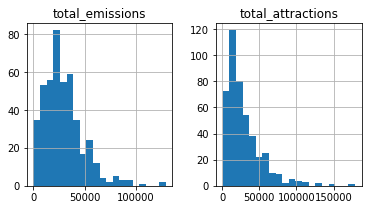

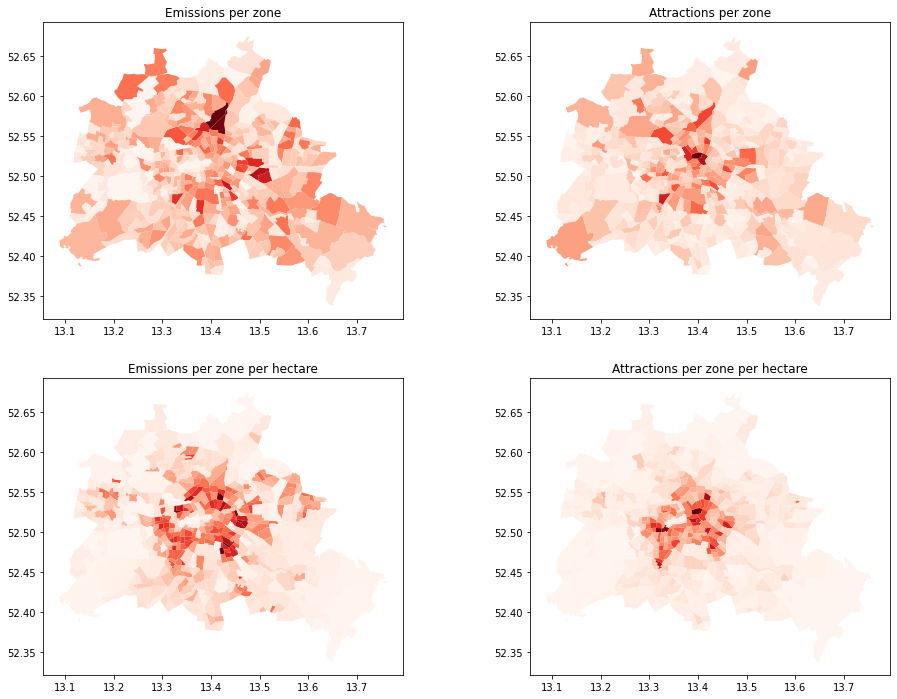

In [153]:
if show_plots:
    sm.zones[['total_emissions', 'total_attractions']].hist(bins=20, figsize=(6,3))
    fig, ax = plt.subplots(2, 2, figsize=(16,12))
    sm.zones.plot(ax=ax.flat[0], column='total_emissions', cmap="Reds")
    ax.flat[0].set_title("Emissions per zone")
    sm.zones.plot(ax=ax.flat[1], column='total_attractions', cmap="Reds")
    ax.flat[1].set_title("Attractions per zone")
    sm.zones.plot(ax=ax.flat[2], cmap="Reds", column=np.array([a/g.area for a,g in zip(sm.zones['total_emissions'].values, sm.zones['geometry'].values) ]))
    ax.flat[2].set_title("Emissions per zone per hectare")
    sm.zones.plot(ax=ax.flat[3], cmap="Reds", column=np.array([a/g.area for a,g in zip(sm.zones['total_attractions'].values, sm.zones['geometry'].values) ]))
    ax.flat[3].set_title("Attractions per zone per hectare")

    plt.savefig(output_path+'plots/od_zones'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/od_zones'+'_dpi200.png', dpi=200)
    plt.savefig(output_path+'plots/od_zones'+'_dpi100.png', dpi=100)   


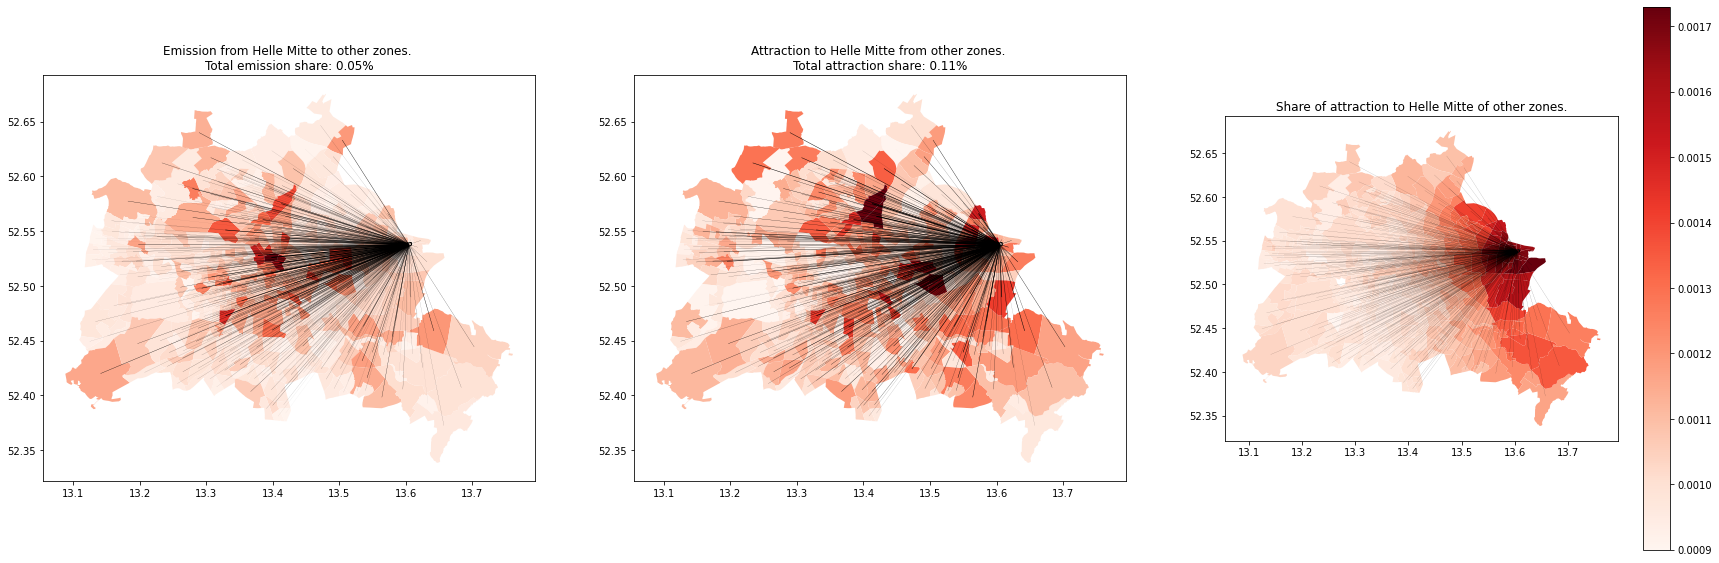

In [154]:
if show_plots:
    N = 1
    fig, ax = plt.subplots(nrows=N, ncols=3, figsize=(30,10*N))
    for (n, ind) in enumerate(np.random.permutation(len(sm.zones))[:N]):
        z_id = sm.zones.index[ind]
        
        z_emission = sm.volumes[['destination', 'all']][sm.volumes['origin']==z_id]
        z_attraction = sm.volumes[['origin', 'all']][sm.volumes['destination']==z_id]
        z_emission_from = np.array([item for sublist in [z_emission['all'][z_emission['destination']==i] for i in sm.zones.index] for item in sublist])
        z_attraction_to = np.array([item for sublist in [z_attraction['all'][z_attraction['origin']==i] for i in sm.zones.index] for item in sublist])

        all_emissions = np.array([sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        all_attractions = np.array([sum(sm.volumes['all'][sm.volumes['destination']==i]) for i in sm.zones.index])
        z_attractions = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].sum() for i in sm.zones.index])
        # z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].iloc[0]/sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].sum() / \
            sm.volumes['all'][sm.volumes['origin']==i].sum() for i in sm.zones.index])


        sm.zones.plot(ax=ax.flat[n*3], cmap="Reds", \
            column=z_emission_from)
        sm.zones.plot(ax=ax.flat[n*3+1], cmap="Reds", \
            column=z_attraction_to)
        sm.zones.plot(ax=ax.flat[n*3+2], cmap="Reds", \
            column=z_attraction_share, legend=True)
        

        z_centroid_coords = sm.zones['geometry'].loc[z_id].centroid.coords[0]
        lines = sm.zones.geometry.apply(lambda g: LineString([z_centroid_coords, g.centroid.centroid.coords[0]]))
        
        lines.plot(ax=ax.flat[n*3], color="black", linewidth=z_emission_from/z_emission_from.max())
        lines.plot(ax=ax.flat[n*3+1], color="black", linewidth=z_attraction_to/z_attraction_to.max())
        lines.plot(ax=ax.flat[n*3+2], color="black", linewidth=z_attraction_share/(all_attractions.max()/sum(all_attractions))*1)
        
        
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+1], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+2], color="None", edgecolor='black', linewidth=1)

        ax.flat[n*3].set_title('Emission from '+ str(sm.zones.loc[z_id]['PLANUNGSRA']) + ' to other zones. \nTotal emission share: ' + str(round(100*z_emission_from.sum()/sum(all_attractions),2)) +'%')
        ax.flat[n*3+1].set_title('Attraction to '+ str(sm.zones.loc[z_id]['PLANUNGSRA']) + ' from other zones. \nTotal attraction share: ' + str(round(100*z_attraction_to.sum()/sum(all_emissions),2))+'%')
        ax.flat[n*3+2].set_title('Share of attraction to '+ str(sm.zones.loc[z_id]['PLANUNGSRA']) + ' to other zones emissions.')

        plt.savefig(output_path+'plots/od_zone_inspection_'+str(N)+'_dpi300.png', dpi=300)
        plt.savefig(output_path+'plots/od_zone_inspection_'+str(N)+'_dpi200.png', dpi=200)
        plt.savefig(output_path+'plots/od_zone_inspection_'+str(N)+'_dpi100.png', dpi=100)  


## Step mode choice

For mode choice we apply a nested logit model. In modeling terms, this step can be understood as the "logit" step, because the resulting utilities could also be used to compute the impedance matrix from above. You will see, that the logit step is entirely independent of the volumes and could, thus, be done earlier.

In [164]:
sm.pt_los.head()

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,in_vehicle_length,length,price,scenario,mode_utility,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)",pivot
0,zone_01011101,zone_01011101,0.000000,"(zone_01011101,)",best_path,False,[],[],[],[],...,0.000,0.000000,0.9375,NaN,0,-0.937500,-0.937500,0.500000,0.500000,0.500000
1,zone_01011101,zone_01011102,1531.562745,"(zone_01011101, n_node_de:11000:900005101::1, ...",best_path,False,"[n_node_de:11000:900005101::1, n_node_de:11000...","[n_node_de:11000:900023201::6, n_node_de:11000...","[n_node_de:11000:900005101::1, n_node_de:11000...","[link_5919, link_5920, link_12185]",...,2535.320,3379.380312,0.9375,NaN,0,-1.779860,-1.779860,0.259357,0.259357,0.259357
2,zone_01011101,zone_01011103,1269.963307,"(zone_01011101, n_node_de:11000:900005103::4, ...",best_path,False,[n_node_de:11000:900005103::1],[n_node_de:11000:900005155::1],"[n_node_de:11000:900005103::4, n_node_de:11000...","[link_10227, link_10228]",...,681.755,1501.364665,0.9375,NaN,0,-1.635980,-1.635980,0.288946,0.288946,0.288946
3,zone_01011101,zone_01011104,1473.498877,"(zone_01011101, n_node_de:11000:900005103::4, ...",best_path,False,[n_node_de:11000:900005103::1],[n_node_de:11000:900005205::4],"[n_node_de:11000:900005103::4, n_node_de:11000...","[link_10273, link_10274, link_10275, link_10276]",...,1564.457,2440.496344,0.9375,NaN,0,-1.747924,-1.747924,0.275448,0.275448,0.275448
4,zone_01011101,zone_01011105,1082.024697,"(zone_01011101, n_node_de:11000:900005101::2, ...",best_path,False,[n_node_de:11000:900005101::2],[n_node_de:11000:900005206::1],"[n_node_de:11000:900005101::2, n_node_de:11000...","[link_5924, link_5925, link_5926, link_5927]",...,2296.131,2597.818248,0.9375,NaN,0,-1.532614,-1.532614,0.359662,0.359662,0.359662


In [163]:
sm.car_los.head()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type,scenario,price
0,zone_01011101,zone_01011101,0.000000,[zone_01011101],[],[],[],0.000,"(car,)",car,cars,0.000000
1,zone_01011101,zone_01011102,537.149979,"[zone_01011101, 26704697, 26704698, 26874394, ...","[26704697, 26704698, 26874394, 26745299, 26704...","[75596, 78903, 7686, 75464, 78907, 78910, 122820]","[(zone_01011101, 26704697), (1363120037, zone_...",838.879,"(car,)",car,cars,0.100665
2,zone_01011101,zone_01011103,338.121859,"[zone_01011101, 26704697, 26704088, 26916066, ...","[26704697, 26704088, 26916066, 20246267, 26866...","[75458, 79367, 8446, 428, 7418, 7530, 6654, 38...","[(zone_01011101, 26704697), (388310225, zone_0...",1695.279,"(car,)",car,cars,0.203433
3,zone_01011101,zone_01011104,450.669491,"[zone_01011101, 26704697, 26704088, 26916066, ...","[26704697, 26704088, 26916066, 20246267, 26866...","[75458, 79367, 8446, 428, 7419, 37935, 6697, 7...","[(zone_01011101, 26704697), (26765676, zone_01...",2009.730,"(car,)",car,cars,0.241168
4,zone_01011101,zone_01011105,348.592440,"[zone_01011101, 26704697, 26704698, 26874394, ...","[26704697, 26704698, 26874394, 26745299, 26874...","[75596, 78903, 7686, 4937, 7690, 2681, 2676, 1...","[(zone_01011101, 26704697), (1257899084, zone_...",2101.407,"(car,)",car,cars,0.252169


In [168]:
list(sm.pt_los['route_type'].unique())

['bus', 'subway', 'rail', 'tram', 'bike']

In [155]:
sm.utilities

route_type,origin,destination,segment,root,car,walk,pt,subway,bus,rail,tram,bike
0,zone_01022204,zone_01011101,car_owner,-1.144260,-inf,-inf,-1.144260,-inf,-1.692486,-inf,-inf,-1.347533
1,zone_01022204,zone_01011101,pt_captive,-1.144260,-inf,-inf,-1.144260,-inf,-1.692486,-inf,-inf,-1.347533
2,zone_01022204,zone_01011102,car_owner,-1.160846,-inf,-inf,-1.160846,-1.727209,-inf,-inf,-inf,-1.355264
3,zone_01022204,zone_01011102,pt_captive,-1.160846,-inf,-inf,-1.160846,-1.727209,-inf,-inf,-inf,-1.355264
4,zone_01022204,zone_01011103,car_owner,-1.235122,-inf,-inf,-1.235122,-inf,-1.882308,-inf,-inf,-1.395273
...,...,...,...,...,...,...,...,...,...,...,...,...
39419,zone_12302211,zone_12302212,pt_captive,-1.070616,-inf,-inf,-1.070616,-inf,-1.611926,-inf,-inf,-1.277396
39420,zone_12302211,zone_12304313,car_owner,-1.399791,-inf,-inf,-1.399791,-inf,-2.280109,-inf,-inf,-1.494123
39421,zone_12302211,zone_12304313,pt_captive,-1.399791,-inf,-inf,-1.399791,-inf,-2.280109,-inf,-inf,-1.494123
39422,zone_12302211,zone_12304314,car_owner,-1.365547,-inf,-inf,-1.365547,-inf,-2.168269,-inf,-inf,-1.477620


In [156]:
# First, we need parameters for our logit model.
# We define the nesting structure (i.e. choice tree)
# and the beta parameters which should come from a calibration
# using a mobility survey.
sm.preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
)
# For nest parameters you should take 1 >= mode >= pt_mode >= pt_path > 0

In [157]:
# Now we have generated the nesting structure table
# Can differ by demand segment, if you want
sm.mode_nests

segment,root,car_owner,pt_captive
route_type,,,
bike,pt,pt,pt
tram,pt,pt,pt
walk,root,root,root
rail,pt,pt,pt
bus,pt,pt,pt
subway,pt,pt,pt
root,NaN,NaN,NaN
car,root,root,root
pt,root,root,root


In [158]:
# And the corresponding theta values
sm.logit_scales

segment,root,car_owner,pt_captive
route_type,,,
bike,0.1,0.1,0.1
tram,0.1,0.1,0.1
walk,0.0,0.0,0.0
rail,0.1,0.1,0.1
bus,0.1,0.1,0.1
subway,0.1,0.1,0.1
root,1.0,1.0,1.0
car,0.0,0.0,0.0
pt,0.5,0.5,0.5


In [159]:
# And the Alternative-Specific-Constants (ASC)
# We have to prevent PT captives from using a car
# sm.mode_utility.loc['bike'] = -.6
# sm.mode_utility.loc['tram'] = -.1
# sm.mode_utility.loc['rail'] = -.1
# # sm.mode_utility.loc['bus'] = -.0
# # sm.mode_utility.loc['walk'] = 0
# # sm.mode_utility.loc['car'] = 0
# sm.mode_utility.loc['subway'] = -.1
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility

segment,root,car_owner,pt_captive
route_type,,,
bike,0,0,0
tram,0,0,0
walk,0,0,0
rail,0,0,0
bus,0,0,0
subway,0,0,0
root,0,0,0
car,0,0,-100


In [160]:
# And the beta parameters
# The column 'mode_utility' refers to the weight of the ASC table
# Delete the transfers attribute because we don't want it in our model formulation
if 'ntransfers' in sm.utility_values.columns: 
    sm.utility_values.drop('ntransfers', inplace=True)
sm.utility_values

segment,root,car_owner,pt_captive
value,,,
time,-0.00055,-0.00055,-0.00055
price,-1.00000,-1.00000,-1.00000
ntransfers,0.00000,0.00000,0.00000
mode_utility,1.00000,1.00000,1.00000


In [161]:
# Now, add segment specific ASC column to LoS table.
# But first we have to generate a combined LoS table
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['route_types'] = sm.los['route_types'].apply(tuple)# bugfix
sm.analysis_mode_utility(how='main', # how refers to how to calculate the ASC from multiple paths
                         segment=None) # automatically iterates through segments

100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


In [162]:
if sm.utilities['car'].max() < -1e20:
    fehler 

NameError: name 'fehler' is not defined

In [ ]:
# Finally, run the logit model
sm.initialize_logit()
# If you want to know what parameters you can give to the function,
# look into the code. You can find the most important functions in
# the quetzal/model/transportmodel.py file, which refers to sub-functions
# by importing them from other quetzal files
sm.step_logit()

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


In [ ]:
if sm.utilities['car'].max() < -1e20:
    fehler 

NameError: name 'fehler' is not defined

In [ ]:
# The result is a utilities table
sm.utilities.head(3)

route_type,origin,destination,segment,root,car,walk,pt,subway,bus,rail,tram,bike
0,zone_01022204,zone_01011101,car_owner,-1.144260,-inf,-inf,-1.144260,-inf,-1.692486,-inf,-inf,-1.347533
1,zone_01022204,zone_01011101,pt_captive,-1.144260,-inf,-inf,-1.144260,-inf,-1.692486,-inf,-inf,-1.347533
2,zone_01022204,zone_01011102,car_owner,-1.160846,-inf,-inf,-1.160846,-1.727209,-inf,-inf,-inf,-1.355264


In [ ]:
# and the probabilities
sm.probabilities.head(3)

route_type,origin,destination,segment,root,car,walk,pt,subway,bus,rail,tram,bike
0,zone_01022204,zone_01011101,car_owner,1,0.0,0.0,1.0,0.000000,0.334054,0.0,0.0,0.665946
1,zone_01022204,zone_01011101,pt_captive,1,0.0,0.0,1.0,0.000000,0.334054,0.0,0.0,0.665946
2,zone_01022204,zone_01011102,car_owner,1,0.0,0.0,1.0,0.322154,0.000000,0.0,0.0,0.677846


In [ ]:
# Moreover, you have now probabilities assigned to your paths!
sm.los.head(3)

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,in_vehicle_length,length,price,scenario,mode_utility,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)",pivot
0,zone_01011101,zone_01011101,0.000000,"(zone_01011101,)",best_path,False,[],[],[],[],...,0.000,0.000000,0.9375,NaN,0,-0.93750,-0.93750,0.500000,0.500000,0.500000
1,zone_01011101,zone_01011102,1531.562745,"(zone_01011101, n_node_de:11000:900005101::1, ...",best_path,False,"[n_node_de:11000:900005101::1, n_node_de:11000...","[n_node_de:11000:900023201::6, n_node_de:11000...","[n_node_de:11000:900005101::1, n_node_de:11000...","[link_5919, link_5920, link_12185]",...,2535.320,3379.380312,0.9375,NaN,0,-1.77986,-1.77986,0.259357,0.259357,0.259357
2,zone_01011101,zone_01011103,1269.963307,"(zone_01011101, n_node_de:11000:900005103::4, ...",best_path,False,[n_node_de:11000:900005103::1],[n_node_de:11000:900005155::1],"[n_node_de:11000:900005103::4, n_node_de:11000...","[link_10227, link_10228]",...,681.755,1501.364665,0.9375,NaN,0,-1.63598,-1.63598,0.288946,0.288946,0.288946


## Step assignment

This step combines the path probabilities with the volumes and loads them onto the networks.

In [ ]:
sm.volumes.head(2)

,origin,destination,car_owner,pt_captive,all
0,zone_01011101,zone_01011101,8.125213,18.261913,26.387125
1,zone_01011101,zone_01011102,7.110537,15.696724,22.807261


In [ ]:
# We want to do an assignment for cars and PT seperately
# (although there is a wrapper function in quetzal)
# Therefore, we must transfer the path probabilities to pt_los and car_los
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']

In [ ]:
# PT first
sm.segmented_pt_assignment(split_by='route_type', # identify from which route type the load comes
                           on_road_links=False, # load bus traffic to the road network (requires casted networks)
                           path_column='link_path' # pt_los column with the path list
                          )

pt_captive:  50%|█████     | 1/2 [00:11<00:11, 11.86s/it]


KeyboardInterrupt: 

In [ ]:
# Now cars
sm.segmented_car_assignment()

pt_captive: 100%|██████████| 2/2 [00:34<00:00, 17.07s/it]


In [ ]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
if show_plots:
    sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links, crs=sm.epsg)
    sm.road_links = gpd.GeoDataFrame(sm.road_links, crs=sm.epsg)
    scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / (35/2)

    fig, ax = plt.subplots(figsize = (10,10))
    sm.zones.plot(ax=ax, alpha=.2, color='green')
    sm.loaded_links.plot(ax=ax, alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler))
    sm.road_links.plot(ax=ax, alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler))

    # sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    #     ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
    #         ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))
    plt.savefig(output_path+'plots/network_load_pt_blue'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/network_load_pt_blue'+'_dpi200.png', dpi=200)
    plt.savefig(output_path+'plots/network_load_pt_blue'+'_dpi100.png', dpi=100)  

## Read in validation data
To-Do:
- Maybe the addition of validation data can be moved to an earlier step in the process (Maybe directly after network creation)

In [ ]:
traffic_validation = gpd.read_file(input_path + "validation/Verkehrsmengen.shp")
traffic_validation.to_crs(epsg=4326, inplace=True)
if show_plots: traffic_validation.plot(cmap="Reds", column='dtvw_kfz')
traffic_validation.sample(1)


,link_id,elem_nr,vnp,nnp,vst,bst,vricht,ebene,str_typ,strklasse1,strklasse,strklasse2,str_name,bezirk,stadtteil,dtvw_kfz,dtvw_lkw,geometry
6916,38540053_38540058,38540053_38540058.02,38540053.0,38540058.0,0.0,93.0,R,0.0,S,II,G,STRA,Messedamm,Charlottenburg-Wilmersdorf,Westend,5900.0,500.0,"LINESTRING (13.28182 52.50959, 13.28168 52.509..."


In [ ]:
sm.road_links.head()

,a,b,length,validation_load,validation_share,geometry,highway,maxspeed,validation_threshold,avspeed,time,walk_time,index,"(car_owner, car)","(pt_captive, car)","(all, car)"
index,,,,,,,,,,,,,,,,
1,172539,34694265,237.653,10379.796248,1.000000,"LINESTRING (13.33550 52.56521, 13.33859 52.56428)",tertiary,50,True,35.0,24.444309,171.11016,1,NaN,NaN,0.0
2,172539,34694336,687.484,13820.164605,1.000000,"LINESTRING (13.33550 52.56521, 13.34515 52.56680)",secondary,50,True,35.0,70.712640,494.98848,2,NaN,NaN,0.0
3,172539,3977742457,391.153,19240.567732,1.000000,"LINESTRING (13.33550 52.56521, 13.33114 52.56289)",secondary,50,True,35.0,40.232880,281.63016,3,NaN,NaN,0.0
4,172545,271370539,17.179,12033.495869,0.881115,"LINESTRING (13.34661 52.56703, 13.34664 52.56688)",tertiary,50,False,35.0,1.766983,12.36888,4,NaN,NaN,0.0
5,172545,28345515,171.849,9612.436767,1.000000,"LINESTRING (13.34661 52.56703, 13.34681 52.56857)",tertiary,50,True,35.0,17.675897,123.73128,5,NaN,NaN,0.0


In [ ]:
if show_plots:
    scaler_v = traffic_validation['dtvw_kfz'].max() / (35)


    fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (16,12), sharex='all', sharey='all')
    sm.zones.plot(ax=ax.flat[0], alpha=.2, color='#cccccc')
    sm.zones.plot(ax=ax.flat[1], alpha=.2, color='#cccccc')
    sm.zones.plot(ax=ax.flat[2], alpha=.2, color='#cccccc')
    sm.zones.plot(ax=ax.flat[3], alpha=.2, color='#cccccc')

    traffic_validation.plot(ax=ax.flat[0], alpha=.3, color="blue", linewidth=list(traffic_validation['dtvw_kfz']/(scaler)))
    sm.road_links.plot(ax=ax.flat[1], alpha=.3, color='blue', linewidth=list(sm.road_links[('all', 'car')]/scaler))
    ratio=sm.road_links[('all', 'car')][sm.road_links['validation_threshold']].sum()/sm.road_links['validation_load'][sm.road_links['validation_threshold']].sum()
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[2], alpha=.3, color='blue', linewidth=list(sm.road_links['validation_load'][sm.road_links['validation_threshold']]/scaler))
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[3], alpha=.3, color='blue', linewidth=list(sm.road_links[('all', 'car')][sm.road_links['validation_threshold']]/(scaler)))
    ax.flat[0].set_title('traffic load on roads based on validation data')
    ax.flat[1].set_title('traffic load on roads based on model ouput')
    ax.flat[2].set_title('traffic load on roads based on validation data')
    ax.flat[3].set_title('traffic load on roads based on model ouput')
    
    plt.savefig(output_path+'plots/road_network_vs_validation'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/road_network_vs_validation'+'_dpi200.png', dpi=200)
    plt.savefig(output_path+'plots/road_network_vs_validation'+'_dpi100.png', dpi=100)  


#### Validation data and sm.road_links

In [ ]:
sm.pt_los.iloc[-2]['price']

0.5338775999999998

In [ ]:
sm.car_los.iloc[-2]['price']

0.23001491999999996

In [ ]:
total_load_network = sum(sm.road_links[('all', 'car')][sm.road_links['validation_threshold']])
total_load_validation = sum(sm.road_links['validation_load'][sm.road_links['validation_threshold']])
print('network:', total_load_network, 
    'validation:',  total_load_validation, 'ratio n/v:', round(total_load_network/total_load_validation,3))

r_gdf = GeoDataFrame({
    'ratio': total_load_validation/total_load_network * sm.road_links[('all', 'car')][sm.road_links['validation_threshold']] / sm.road_links['validation_load'][sm.road_links['validation_threshold']]
    }, geometry=sm.road_links['geometry'][sm.road_links['validation_threshold']], crs=sm.epsg)

# ax0 = r_gdf['ratio'].hist(bins=100)
r_gdf['ratio_cut']=[x if x<2 else 2 for x in r_gdf['ratio']]
ax1 = r_gdf['ratio_cut'].hist(bins=100)


network: 0.0 validation: 249346530.4071401 ratio n/v: 0.0


ZeroDivisionError: float division by zero

In [ ]:

# what can be a validation parameter?
# maybe correlation of shares

load_network = sm.road_links[('all', 'car')][sm.road_links['validation_threshold']] #sum()
load_validation = sm.road_links['validation_load'][sm.road_links['validation_threshold']] #sum()

load_share_network = load_network/load_network.sum()
load_share_validation = load_validation/load_validation.sum()

corr = np.corrcoef(load_share_network, load_share_validation)[0,1]
print(corr)

0.43280052522719914


In [ ]:
load_network.sum(), load_validation.sum(), load_network.sum()/ load_validation.sum()

(88306231.93526869, 249346530.40713876, 0.3541506344246308)

In [ ]:
if show_plots:
    fig, ax = plt.subplots(ncols=2, figsize = (28,16), sharex='all', sharey='all')
    sm.road_links.plot(ax=ax.flat[0], color="#cccccc", linewidth=0.25)
    sm.road_links.plot(ax=ax.flat[1], color="#cccccc", linewidth=0.25)
    col0 = np.array([x for x in sm.road_links[('all', 'car')][(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)]])
    col1 = np.array([x for x in sm.road_links['validation_load'][(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)]])
    sm.road_links[(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)].plot(ax=ax.flat[0], column=col0, cmap='coolwarm')#, legend=True
    sm.road_links[(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)].plot(ax=ax.flat[1], column=col1, cmap='coolwarm')#, legend=True
    ax.flat[0].set_title("Traffic load validation data")
    ax.flat[1].set_title("Traffic load model")


In [ ]:
if show_plots:
    fig, ax = plt.subplots(figsize = (16,16))
    sm.road_links.plot(ax=ax, color="#cccccc", linewidth=0.25)
    r_gdf.plot(ax=ax, cmap='coolwarm', legend=True)
    ax.set_title("Blue: Model predicts less traffic than validation data, Red: model predicts to much traffic")

#### Validation data and sm.loaded_links

In [ ]:
# total_load_network_l = sum(sm.loaded_links['load'][sm.loaded_links['validation_threshold']])
# total_load_validation = sum(sm.loaded_links['validation_load'][sm.loaded_links['validation_threshold']])
# print('network:', total_load_network_l, 
#     'validation:',  total_load_validation, 'ratio n/v:', round(total_load_network_l/total_load_validation,3))

## Model Results

In [ ]:
# Summary of LoS table using a quetzal function
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # seconds per ride
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per ride

In [ ]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'time')] = od_sum[(seg, 'time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

In [ ]:
od_sum.sample(3)

segment                            car_owner                      \
sum                                   volume     price      time   
origin        destination   mode                                   
zone_10020623 zone_09051702 bike    3.938006  0.176324  0.092590   
zone_01011201 zone_07010101 subway  1.437551  0.094831  0.044843   
zone_10040829 zone_12302211 car     1.887561  1.237443  0.320023   

segment                                                                   \
sum                                in_vehicle_time     length ntransfers   
origin        destination   mode                                           
zone_10020623 zone_09051702 bike          0.092590   1.469370   0.000000   
zone_01011201 zone_07010101 subway        0.016859   0.624326   0.101153   
zone_10040829 zone_12302211 car           0.000000  10.312021   0.000000   

segment                               pt_captive                              \
sum                                       volume         price          time   
origin        destination   mode                                               
zone_10020623 zone_09051702 bike    2.913553e+01  6.234745e-01  3.273941e-01   
zone_01011201 zone_07010101 subway  9.742323e+00  3.044158e-01  1.439504e-01   
zone_10040829 zone_12302211 car     1.996471e-43  6.409215e-44  1.657526e-44   

segment                                             ...                  root  \
sum                                in_vehicle_time  ... ntransfers     volume   
origin        destination   mode                    ...                         
zone_10020623 zone_09051702 bike          0.327394  ...    0.00000  33.073533   
zone_01011201 zone_07010101 subway        0.054118  ...    0.32471  11.179874   
zone_10040829 zone_12302211 car           0.000000  ...    0.00000   1.887561   

segment                                                                 \
sum                                    price      time in_vehicle_time   
origin        destination   mode                                         
zone_10020623 zone_09051702 bike    0.570233  0.299436        0.299436   
zone_01011201 zone_07010101 subway  0.277467  0.131207        0.049327   
zone_10040829 zone_12302211 car     1.237443  0.320023        0.000000   

segment                                                   car_owner  \
sum                                    length ntransfers        pkm   
origin        destination   mode                                      
zone_10020623 zone_09051702 bike     4.751943   0.000000   5.786386   
zone_01011201 zone_07010101 subway   1.826722   0.295964   0.897501   
zone_10040829 zone_12302211 car     10.312021   0.000000  19.464573   

segment                               pt_captive        root  
sum                                          pkm         pkm  
origin        destination   mode                              
zone_10020623 zone_09051702 bike    1.513771e+02  157.163530  
zone_01011201 zone_07010101 subway  1.952502e+01   20.422520  
zone_10040829 zone_12302211 car     1.066318e-85   19.464573  

[3 rows x 21 columns]

segment,car_owner,pt_captive,root,validation
sum,volume,volume,volume,
mode,,,,
bike,0.10,0.35,0.27,0.18
bus,0.01,0.02,0.02,0.05
car,0.65,0.00,0.21,0.26
rail,0.18,0.43,0.35,0.11
subway,0.06,0.18,0.14,0.08
tram,0.00,0.02,0.01,0.02


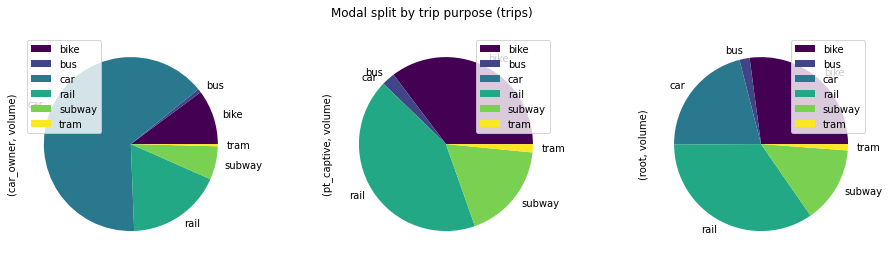

In [ ]:
n_trips = od_sum.loc[:, [(seg, 'volume') for seg in sm.segments+['root']]].groupby(level=2).sum()
n_trips.plot.pie(
    subplots=True, figsize=(16, 4), legend=True, title='Modal split by trip purpose (trips)', cmap="viridis")
percentage_n_trips =  n_trips / sum([n_trips.iloc[n] for n in range(len(n_trips))])
percentage_n_trips['validation'] = [modalsplit_prozent_wege_berlin['Alle Wege'].loc[i] for i in percentage_n_trips.index.values]
percentage_n_trips.round(2)


segment,car_owner,pt_captive,root
sum,pkm,pkm,pkm
mode,,,
bike,0.01,0.10,0.08
bus,0.00,0.01,0.01
car,0.63,0.00,0.14
rail,0.30,0.72,0.63
subway,0.05,0.16,0.14
tram,0.00,0.01,0.01


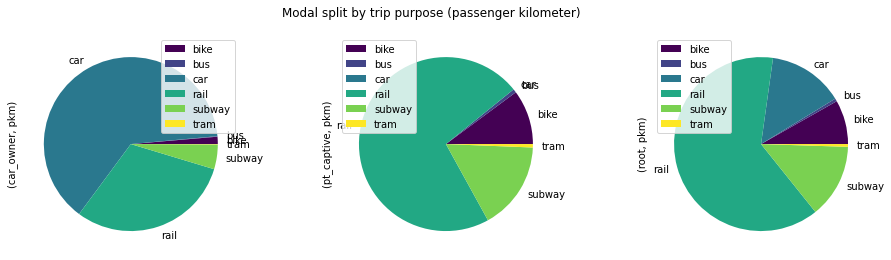

In [ ]:
km_trips = od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments+['root']]].groupby(level=2).sum()

km_trips.plot.pie(subplots=True, figsize=(16, 4), legend=True, title='Modal split by trip purpose (passenger kilometer)', cmap="viridis")

percentage_km_trips =  km_trips / sum([km_trips.iloc[n] for n in range(len(km_trips))])
percentage_km_trips.round(2)

In [ ]:
# calcualte total time travelled in hours
inside_only = [(o in inside_zone_ids and d in inside_zone_ids) for o,d,m in od_sum.index.values]
outside_only = [(o in outside_zone_ids and d in outside_zone_ids) for o,d,m in od_sum.index.values]
mix_only = [not (o in inside_zone_ids) == (d in inside_zone_ids) for o,d,m in od_sum.index.values]


print([(seg, round(sum(od_sum[(seg, 'volume')]*od_sum[(seg, 'time')])/(60**2))) for seg in sm.segments + ['root']])
print([(seg, round(sum(od_sum[(seg, 'volume')][inside_only]*od_sum[(seg, 'time')][inside_only])/(60**2))) for seg in sm.segments + ['root']])
print([(seg, round(sum(od_sum[(seg, 'volume')][outside_only]*od_sum[(seg, 'time')][outside_only])/(60**2))) for seg in sm.segments + ['root']])
print([(seg, round(sum(od_sum[(seg, 'volume')][mix_only]*od_sum[(seg, 'time')][mix_only])/(60**2))) for seg in sm.segments + ['root']])



[('car_owner', 1222492.2939722931), ('pt_captive', 5393314.210663948), ('root', 6615806.504636167)]
[('car_owner', 77787.86486437189), ('pt_captive', 286365.24952121906), ('root', 364153.1143855928)]
[('car_owner', 624052.3720058996), ('pt_captive', 2825251.3462992758), ('root', 3449303.7183052357)]
[('car_owner', 520652.0571020381), ('pt_captive', 2281697.6148435352), ('root', 2802349.6719455626)]


In [ ]:
# 

# [('car_owner', 340), ('pt_captive', 1498), ('root', 1838)]
# [('car_owner', 22), ('pt_captive', 80), ('root', 101)]
# [('car_owner', 173), ('pt_captive', 785), ('root', 958)]
# [('car_owner', 145), ('pt_captive', 634), ('root', 778)]



[('car_owner', 340), ('pt_captive', 1498), ('root', 1838)]
[('car_owner', 22), ('pt_captive', 80), ('root', 101)]
[('car_owner', 173), ('pt_captive', 785), ('root', 958)]
[('car_owner', 145), ('pt_captive', 634), ('root', 778)]


In [ ]:
# calcualte total time travelled by mode
inside_only = [(o in inside_zone_ids and d in inside_zone_ids) for o,d,m in od_sum.index.values]
outside_only = [(o in outside_zone_ids and d in outside_zone_ids) for o,d,m in od_sum.index.values]
mix_only = [not (o in inside_zone_ids) == (d in inside_zone_ids) for o,d,m in od_sum.index.values]


print([(seg, sum(od_sum[(seg, 'volume')]*od_sum[(seg, 'length')])) for seg in sm.segments + ['root']])
print([(seg, sum(od_sum[(seg, 'volume')][inside_only]*od_sum[(seg, 'time')][inside_only])) for seg in sm.segments + ['root']])
print([(seg, sum(od_sum[(seg, 'volume')][outside_only]*od_sum[(seg, 'time')][outside_only])) for seg in sm.segments + ['root']])
print([(seg, sum(od_sum[(seg, 'volume')][mix_only]*od_sum[(seg, 'time')][mix_only])) for seg in sm.segments + ['root']])



## Save model

In [ ]:
Save the od_sum as Excel
# if not os.path.exists('../outputs/'):
#     os.makedirs('../outputs/')
# with pd.ExcelWriter('../outputs/od_summary.xlsx') as writer:  
#     od_sum.to_excel(writer, sheet_name='od_sum')

SyntaxError: invalid syntax (<ipython-input-622-eab586da6d10>, line 1)

In [ ]:
# make sure that all tables have unique indicies before saving
sm.probabilities.reset_index(inplace=True, drop=True)
sm.utilities.reset_index(inplace=True, drop=True)

In [ ]:
sm.to_json(model_path + 'four_steps')

to_hdf(overwriting):  60%|██████    | 27/45 [01:49<00:29,  1.66s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|██████████| 45/45 [02:48<00:00,  3.74s/it]

could not save attribute: parameters
